In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("Traffic.ipynb")

# Final Project: Traffic
## Due Date: Monday, December 13th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions within your own groups**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.

# Data 100 Final Project: Traffic in a post-lockdown world

**Scenario:** You're a data scientist at Uber -- sitting in a war room on March 16, 2020, 1 day after California-wide COVID lockdown measures began and the day shelter-in-place measures are announced in the bay area. The entire data science department is on fire: All of your existing traffic models have regressed *significantly*. Given the sudden change in traffic patterns (i.e., no traffic at all), the company's traffic estimates are wildly incorrect. This is a top priority for the company. Since traffic estimates are used directly for pricing strategies, this is actively costing the company millions every hour. You are tasked with fixing these models.

**Takeaways:** How do you "fix" models that have learned biases from pre-lockdown traffic? How do you train new ones, with just 24 hours of data? What sorts of data do you examine, to better understand the situation? In the midst of company-wide panic, you'll need a strong inferential acumen to lead a robust data science response. In this project, we'll walk you through a simulated war room data science effort, culminating in some strategies to fix models online, which are experiencing large distributional shifts in data.

For this project, we'll explore traffic data provided by the **Uber Movement** dataset, specifically around the start of COVID shutdowns in March 2020. Your project is structured around the following ideas:

```
1. Guided data cleaning: Clustering data spatially
    a. Load Uber traffic speeds dataset
    b. Map traffic speeds to Google Plus Codes (spatially uniform)
        i. Load node-to-gps-coordinates data
        ii. Map traffic speed to GPS coordinates
        iii. Convert GPS coordinates to plus code regions
        iv. Sanity check number of plus code regions in San Francisco
        v. Plot a histogram of the standard deviation in speed, per plus code region.
    c. Map traffic speeds to census tracts (spatially non-uniform)
        i. Download census tracts geojson
        ii. Map traffic speed to census tracts
        iii. Sanity check number of census tracts in San Francisco with data.
        iv. Plot a histogram of the standard deviation in speed, per census tract.
    d. What defines a "good" or "bad" spatial clustering?
2. Guided EDA: Understanding COVID lockdown impact on traffic
    a. How did lockdown affect average traffic speeds?
        i. Sort census tracts by average speed, pre-lockdown.
        ii. Sort census tracts by average speed, post-lockdown.
        iii. Sort census tracts by change in average speed, from pre to post lockdown.
        iv. Quantify the impact of lockdown on average speeds.
        v. Quantify the impact of pre-lockdown average speed on change in speed.
    b. What traffic areas were impacted by lockdown?
        i. Visualize heatmap of average traffic speed per census tract, pre-lockdown.
        ii. Visualize change in average daily speeds pre vs. post lockdown.
        iii. Quantify the impact of lockdown on daily speeds, spatially.
3. Open-Ended EDA: Understanding lockdown impact on traffic times
    a. Download Uber Movement (Travel Times) dataset
4. Guided Modeling: Predict traffic speed post-lockdown
    a. Predict daily traffic speed on pre-lockdown data
        i. Assemble dataset to predict daily traffic speed.
        ii. Train and evaluate linear model on pre-lockdown data.
    b. Understand failures on post-lockdown data
        i. Evaluate on post-lockdown data
        ii. Report model performance temporally
    c. "Fix" model on post-lockdown data
        i. Learn delta off of a moving bias
        ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?
        iii. Naively retrain model with post-lockdown data
        iv. What if you just ignore the change point?
5. Open-Ended Modeling: Predicting travel times post-lockdown
```

Concepts tested: regex, pivot, join, grouping, inferential thinking

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import csv
import json
import os
import contextily as cx
from collections import defaultdict
import re
from typing import Callable

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from zipfile import ZipFile
zf = ZipFile('data.zip', 'r')
zf.extractall('.')

# more readable exceptions
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.


# Step 1 - Guided Data Cleaning: Partitioning Data Spatially

Our hope is answer: How do we group information spatially? We'll specifically look at 2 ways of partitioning data spatially, to understand the impact of spatial partitioning strategies on our analyses:

1. Dividing the world uniformly into slices, like Google's plus codes.
2. Dividing the world according to population, using census tracts.

In this step, we'll load the following datasets that we'll need for this project:

- Daily travel times from Uber Movement data in March 2020 from San Francisco, by census tract
- Daily traffic speeds from Uber Movement data in Q1 2020 from San Francisco, between OSM nodes
- Census tracts dividing San Francisco by GPS coordinates
- Mapping from OSM nodes to GPS coordinates

There are several terms and concepts to get familiar with upfront:

- **Open Street Maps (OSM)** provides nodes (points in space, [wiki](https://wiki.openstreetmap.org/wiki/Node)) and ways (segments between nodes [wiki](https://wiki.openstreetmap.org/wiki/Way)). These IDs are used in the Uber Movement dataset to identify streets in the traffic speeds dataset.
- **Census Tracts** provided by the county of San Francisco geographically divides space according to the US 2010 Census. This is used in the Uber Movement dataset to identify regions of differing travel times.

## 1.a. Load Uber traffic speeds dataset

The dataset is located at `data/movement-speeds-daily-san-francisco-2020-3.csv`. **Load this dataset into a dataframe.**

*The original dataset from Uber was provided hourly and took up 2.1 GB on disk, which means it couldn't fit into your 1GB of RAM. You can find the dataset preparation script at `data/PrepareTrafficDataset.ipynb` which aggregated within each day, reducing the dataset to just 55MB on disk.*

*This was originally going to be question in this project, but it takes 22 minutes to run. Better yet, if you mess up, your kernel dies and you start over. We deemed it too frustrating and preprocessed the dataset to spare you the pain... but just know that this is a real-world issue!*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [3]:
# Load Uber Movement (Movement Speeds) dataset into dataframe
speeds_to_nodes = pd.read_csv(r'data/movement-speeds-daily-san-francisco-2020-3.csv')
speeds_to_nodes

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean
0,281266,702258940,1,59.674042
1,281266,702274215,1,68.444042
2,302876,240259516,1,66.446500
3,302878,437325360,1,65.516850
4,302883,65381191,1,61.880556
...,...,...,...,...
1586647,6569140748,1350115374,31,68.484833
1586648,6570476556,4551993266,31,36.837000
1586649,6573249373,4911384010,31,39.021000
1586650,6573553681,256888796,31,68.728333


In [4]:
grader.check("q1a")

q1a results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.b. Map traffic speed to Google Plus Codes

Google Plus Codes divide up the world uniformly into rectangular slices ([link](https://maps.google.com/pluscodes/)). Let's use this to segment traffic speeds spatially. Take a moment to answer: **Is this spatial structure effective for summarizing traffic speed?** Before completing this section, substantiate your answer with examples of your expectations (e.g., we expect A to be separated from B). After completing this section, substantiate your answer with observations you've made.

<!--
BEGIN QUESTION
name: q1b
points: 2
manual: True
-->

_No, while this spatial structure is very effective for giving a universal street address for people or places that don't have one, it lacks in its ability to differentiate between traffic speeds of adjacent roads that would be located within the same small grid. For example let's say we are observing a grid that goes from one exit of a freeway to the next. The grid system would have difficulty determining the difference between the north and south bound traffic speed, if northbound has no traffic and southbound has lots of traffic but they lie within the same grid, how would this spatial structure determine this difference?_

<!-- END QUESTION -->



### 1.b.i. Load Node-to-GPS-Coordinate Data

In this substep, we'll load a mapping from OSM nodes to GPS coordinates. The dataset is provided in a gzip'ed XML file from OpenStreetMaps (OSM). The mapping from OSM nodes to GPS coordinates was downloaded from https://download.bbbike.org/osm/bbbike/SanFrancisco/SanFrancisco.osm.gz. We've downloaded this for you, to avoid any issues with OSM updates.

**If** you try to load the provided `.osm` (an `.xml` in disguise) using Python's built-in XML utilities **(by uncommenting the last 2 lines in the below cell)**, you will hit an out-of-memory error, as your kernel is forced to restart.

In [5]:
# [OSM] - Read the OSM XML and extract mapping from node ID to GPS coordinates
PATH_OSM = os.path.expanduser('data/SanFrancisco.osm')

# Runs out of memory! File itself is 430 MB, even when filtering out
# irrelevant rows, and remaining 3M rows are too expensive to parse,
# resulting in OOM

# import xml.etree.ElementTree as ET
# _tree = ET.parse(PATH_OSM)

Your above code hits a memory error, so instead, we will use our handy-dandy tool--regex--from earlier in the semester to load just the parts of the file that we need. **Given the XML snippet below, write a regex pattern to extract OSM node ID, latitude, and longitude.** (The first capture group should be node ID. The second should be latitude, and the third should be longitude.) A snippet of the XML is included below ([screenshot](https://extract.bbbike.org/extract-screenshots.html)):

```
<?xml version='1.0' encoding='UTF-8'?>
<osm version="0.6" generator="osmconvert 0.8.3">
    <bounds minlat="42.4543" minlon="-2.4761999" maxlat="42.4..."/>
    <node id="26861066" lat="42.471111" lon="-2.454722" version="..."/>
        <tag k="name" v="Camping La Playa"/>
        <tag k="tourism" v="camp_site"/>
        <tag k="operator" v="private"/>
        ...
    </node>
    <node id="34793287" lat="42.4713587" lon="-2.4510783" version="..."/>
        <tag k="created_by" v="JOSM"/>
    </node>
    <node id="34793294" lat="42.4610836" lon="-2.4303622" version="..."/>
    <node id="34793297" lat="42.4548363" lon="-2.4287657" version="..."/>
    ...
</osm>
```

In [6]:
# [OSM] - Read the OSM XML using a regex operation instead.
def read_node_lat_lon(path: str, pattern: str, line_condition: Callable):
    """
    Read the provided path line at a line. If the provided regex pattern
    has a match, return the grouped matches as items in a generator.
    
    :param path: Path to read data from
    :param pattern: Regex pattern to test against each line
    :param line_condition: function that returns if we should check regex
        against current line
    """
    with open(path) as f:
        for line in f:
            result = re.search(pattern, line)
            if result is not None and line_condition(result):
                yield int(result.group(1)), float(result.group(2)), float(result.group(3))

In [7]:
node_ids = set(speeds_to_nodes.osm_start_node_id) | set(speeds_to_nodes.osm_end_node_id)

NODE_PATTERN =  r'id="(-?\d+.\d+)" lat="(-?\d+.\d+)" lon="(-?\d+.\d+)"'

node_to_gps = pd.DataFrame(read_node_lat_lon(
    PATH_OSM,
    pattern=NODE_PATTERN,
    line_condition=lambda result: int(result.group(1)) in node_ids
), columns=['osm_node_id', 'Latitude', 'Longitude'])
node_to_gps

,osm_node_id,Latitude,Longitude
0,26118026,37.675280,-122.389194
1,29891973,37.674935,-122.389130
2,29892598,37.716892,-122.398893
3,30033679,37.599877,-122.376497
4,30033686,37.642167,-122.405946
...,...,...,...
19139,6522255428,37.760543,-122.443563
19140,6522255492,37.759317,-122.444996
19141,6522764204,37.762163,-122.436143
19142,6522764212,37.756061,-122.436761


In [8]:
grader.check("q1bi")

q1bi results: All test cases passed!

### 1.b.ii. Map traffic speed to GPS coordinates.

Traffic speeds are currently connected to OSM nodes. You will then use the mapping from OSM nodes to GPS coordinates, to map traffic speeds to GPS coordinates. **Link each traffic speed measurement to the GPS coordinate of its starting node.**

**Note**: For simplicity, assume each segment is associated with the node it *starts* with. 

**Hint**: Not all nodes are included in the OSM node mapping. Make sure to ignore any nodes without valid GPS coordinates.

<!--
BEGIN QUESTION
name: q1bii
points: 3
-->

In [9]:
# Find mapping from traffic speeds to GPS coordinates
speeds_to_gps = speeds_to_nodes.merge(node_to_gps, right_on='osm_node_id', left_on='osm_start_node_id')
speeds_to_gps

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude
0,26118026,259458979,1,64.478000,26118026,37.675280,-122.389194
1,26118026,259458979,2,62.868208,26118026,37.675280,-122.389194
2,26118026,259458979,3,62.211750,26118026,37.675280,-122.389194
3,26118026,259458979,4,62.192458,26118026,37.675280,-122.389194
4,26118026,259458979,5,61.913292,26118026,37.675280,-122.389194
...,...,...,...,...,...,...,...
417634,4069109544,615120176,30,38.956000,4069109544,37.732039,-122.507126
417635,5448539901,65446993,16,25.627000,5448539901,37.622476,-122.413763
417636,302964668,4069109544,19,40.802000,302964668,37.732418,-122.507206
417637,302964668,4069109544,20,36.076000,302964668,37.732418,-122.507206


In [10]:
grader.check("q1bii")

q1bii results: All test cases passed!

### 1.b.iii. Convert GPS coordinates to plus code regions.

Plus code regions divide up the world into uniformly-sized rectangles, which we will assume is 0.012 degrees latitudiunally and longitudinally. **For each traffic speed row, compute the plus code region it belongs to**, based on its GPS coordinates.

To do this, we suggest computing a latitudinal index `plus_latitude_idx` and a longitudinal index `plus_longitude_idx` for the plus code region each row belongs to. *Make sure these columns are integer-valued*.

**Hint**: If you're running into nans, you did 1.b.ii. incorrectly!

<!--
BEGIN QUESTION
name: q1biii
points: 3
-->

In [11]:
speeds_to_gps["plus_latitude_idx"] = ((speeds_to_gps["Latitude"] + 90) / 0.012).astype(int)
speeds_to_gps["plus_longitude_idx"] = ((speeds_to_gps["Longitude"]  + 180) / 0.012).astype(int)
speeds_to_gps

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx
0,26118026,259458979,1,64.478000,26118026,37.675280,-122.389194,10639,4800
1,26118026,259458979,2,62.868208,26118026,37.675280,-122.389194,10639,4800
2,26118026,259458979,3,62.211750,26118026,37.675280,-122.389194,10639,4800
3,26118026,259458979,4,62.192458,26118026,37.675280,-122.389194,10639,4800
4,26118026,259458979,5,61.913292,26118026,37.675280,-122.389194,10639,4800
...,...,...,...,...,...,...,...,...,...
417634,4069109544,615120176,30,38.956000,4069109544,37.732039,-122.507126,10644,4791
417635,5448539901,65446993,16,25.627000,5448539901,37.622476,-122.413763,10635,4798
417636,302964668,4069109544,19,40.802000,302964668,37.732418,-122.507206,10644,4791
417637,302964668,4069109544,20,36.076000,302964668,37.732418,-122.507206,10644,4791


In [12]:
grader.check("q1biii")

q1biii results: All test cases passed!

### 1.b.iv. Sanity check number of plus code regions in San Francisco.

**Compute the number of unique plus codes found in your dataset**. You're checking that the number isn't ridiculous, like 1, or 100,000 (SF is 231 sq mi, so 100k tracts would average 12 sq ft per tract).

If you followed the suggestion above, this is the number of unique `(plus_latitude_idx, plus_longitude_idx)` pairs.

<!--
BEGIN QUESTION
name: q1biv
points: 4
-->

In [13]:
# You're expecting 276 plus codes here. Don't just type "276" 
# below to pass the autograder. The goal is to sanity check your 
# dataframe!
num_pluscode_regions = len(speeds_to_gps.groupby(["plus_latitude_idx", "plus_longitude_idx"]).count())
num_pluscode_regions

276

In [14]:
grader.check("q1biv")

q1biv results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.b.v. How well do plus code regions summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "plus code region" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use the statistics above to answer these questions, and compute any additional statistics you need. Additionally explain *why these questions are important to assessing the quality of a spatial clustering*.

**Hint**: Run the autograder first to ensure your variance average and average variance are correct, before starting to draw conclusions.

In the first cell, write your written answers. In the second cell, complete the code.

<!--
BEGIN QUESTION
name: q1bv1
points: 2
manual: True
-->



_While the concept of using plus codes does not perfectly capture the intricate differences in traffic speeds, it again consistently comes within a ten mile per hour accuracy for the true speed of traffic. Plus codes do indeed capture meaningful subpopulations and it does so in a manner that is easy to understand as well as adjust if given more data. The differences between subpopulations do outweigh the differences within a subpopulation, because at any given point on a road there is usually at least a difference of ten miles per hour between the slowest and fastest cars. So given the fact that the average standard deviation is only around 9.4 mph, the average variance is indeed reasonable. This implementation of plus codes allows data scientists to create meaningful subpopulations that create a reasonable average variance, and could be furthered by cross-referencing current traffic speed data collected on other platforms such as Waze or Google Maps. While in further exploration of this data we can make these plus codes more specific in order to reduce this average variance._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1bv2
points: 2
manual: True
-->

Text(0.5, 1.0, 'Histogram of the Within-Cluster Standard Deviation 1')

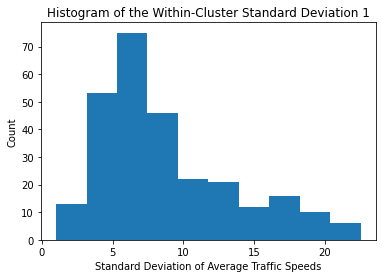

In [15]:
data_grouped = speeds_to_gps.groupby(["plus_latitude_idx", "plus_longitude_idx"])

speed_variance_by_pluscode = data_grouped.var()["speed_mph_mean"] # compute traffic speed variance in each plus code region
# plot a histogram
average_variance_by_pluscode = data_grouped.std()["speed_mph_mean"].mean()
variance_average_by_pluscode = data_grouped.mean()["speed_mph_mean"].std()

variance_average_by_pluscode

data = speeds_to_gps.groupby(["plus_latitude_idx", "plus_longitude_idx"]).std()['speed_mph_mean']

plt.hist(data)
plt.ylabel('Count')
plt.xlabel('Standard Deviation of Average Traffic Speeds')
plt.title('Histogram of the Within-Cluster Standard Deviation 1')

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1bv3
points: 3
-->

In [16]:
speed_variance_by_pluscode

plus_latitude_idx  plus_longitude_idx
10628              4790                   13.324195
                   4802                  428.675799
                   4806                  152.330729
10629              4790                   16.677594
                   4801                  457.571110
                                            ...    
10660              4802                  233.895172
                   4803                  320.979879
                   4804                  202.879917
                   4805                  149.749761
                   4806                  309.436835
Name: speed_mph_mean, Length: 276, dtype: float64

In [17]:
grader.check("q1bv3")

q1bv3 results: All test cases passed!

## 1.c. Map traffic speed to census tract.

Census tracts divide the space much less uniformly, subdividing regions that we were interested in into smaller zones. This suggests promise in providing informative spatial segments. Note that the daily traffic speeds are provided between OpenStreetMap (OSM) nodes, so we'll need to map nodes to census tracts somehow.

Above, we've mapped traffic speeds to GPS coordinates. Below, we'll then link GPS coordinates to census tracts, to complete the mapping from traffic speeds to census tracts.

### 1.c.i. Download Census Tracts Geojson

**Load the census tracts geojson.** Make sure to see the relevant [geopandas io documentation](https://geopandas.org/docs/user_guide/io.html) to see how to load a geojson.

**Hint**: It should take you just one line to load.

<!--
BEGIN QUESTION
name: q1ci
points: 1
-->

In [18]:
PATH_TRACTS = os.path.expanduser('data/san_francisco_censustracts.json')
tract_to_gps = gpd.read_file(PATH_TRACTS)
tract_to_gps['MOVEMENT_ID'] = tract_to_gps['MOVEMENT_ID'].astype(int)
tract_to_gps

,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1,"Sargent Creek, San Ardo","MULTIPOLYGON (((-121.59511 36.11126, -121.5401..."
1,2,"400 Northumberland Avenue, Redwood Oaks, Redwo...","MULTIPOLYGON (((-122.22463 37.46507, -122.2236..."
2,3,"18300 Sutter Boulevard, Morgan Hill","MULTIPOLYGON (((-121.67978 37.15859, -121.6719..."
3,4,"2700 Stoughton Way, Sheffield, Sacramento","MULTIPOLYGON (((-121.35921 38.57175, -121.3462..."
4,5,"3200 Huntsman Drive, Rosemont Park, Sacramento","MULTIPOLYGON (((-121.37512 38.55309, -121.3715..."
...,...,...,...
2705,2706,"10000 Bobbell Drive, Elk Grove","MULTIPOLYGON (((-121.48392 38.40874, -121.4787..."
2706,2707,"400 Ericwood Court, Manteca","MULTIPOLYGON (((-121.22695 37.82647, -121.2185..."
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506..."
2708,2709,"1200 Halyard Drive, West Sacramento","MULTIPOLYGON (((-121.58346 38.57860, -121.5827..."


In [19]:
grader.check("q1ci")

q1ci results: All test cases passed!

### 1.c.ii Map traffic speed to census tracts.

You will need to *spatially join* the (1) mapping from traffic speed to GPS coordinates `speed_to_gps` and (2) the mapping from GPS coordinates to boundaries of census tracts `tract_to_gps` to group all traffic speeds by census tract. This "spatial join" is an advanced feature recently released (as of time of writing, in Oct 2021) in geopandas, which allows us to connect single points to their enclosing polygons. You will do this question in 3 parts:

1. Convert the last dataframe `speeds_to_gps` into a geopandas dataframe `speeds_to_points`, where GPS coordinates are now geopandas points. See this tutorial: https://geopandas.org/gallery/create_geopandas_from_pandas.html#From-longitudes-and-latitudes
2. Set the coordinate-system for the new geopandas dataframe to the "world geodesic system" [link](https://epsg.io/4326), or in other words, the coordinate system that GPS coordinates are reported in.
3. Compute a spatial join between census tracts `tract_to_gps` and the geopandas traffic speeds `speeds_to_points`

<!--
BEGIN QUESTION
name: q1cii
points: 4
-->

In [20]:
speeds_to_points = gpd.GeoDataFrame(speeds_to_gps, geometry=gpd.points_from_xy(speeds_to_gps.Longitude, speeds_to_gps.Latitude)).set_crs("EPSG:4326")
speeds_to_tract = speeds_to_points.sjoin(tract_to_gps, how = "left")

# tract_to_gps # multipolygon
# speeds_to_points #geometry 

speeds_to_tract

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx,geometry,index_right,MOVEMENT_ID,DISPLAY_NAME
0,26118026,259458979,1,64.478000,26118026,37.675280,-122.389194,10639,4800,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
1,26118026,259458979,2,62.868208,26118026,37.675280,-122.389194,10639,4800,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
2,26118026,259458979,3,62.211750,26118026,37.675280,-122.389194,10639,4800,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
3,26118026,259458979,4,62.192458,26118026,37.675280,-122.389194,10639,4800,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
4,26118026,259458979,5,61.913292,26118026,37.675280,-122.389194,10639,4800,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
417634,4069109544,615120176,30,38.956000,4069109544,37.732039,-122.507126,10644,4791,POINT (-122.50713 37.73204),1778,1779,"500 John Muir Drive, Lakeshore, San Francisco"
417635,5448539901,65446993,16,25.627000,5448539901,37.622476,-122.413763,10635,4798,POINT (-122.41376 37.62248),1456,1457,"1500 Donner Avenue, San Bruno"
417636,302964668,4069109544,19,40.802000,302964668,37.732418,-122.507206,10644,4791,POINT (-122.50721 37.73242),1778,1779,"500 John Muir Drive, Lakeshore, San Francisco"
417637,302964668,4069109544,20,36.076000,302964668,37.732418,-122.507206,10644,4791,POINT (-122.50721 37.73242),1778,1779,"500 John Muir Drive, Lakeshore, San Francisco"


In [21]:
grader.check("q1cii")

q1cii results: All test cases passed!

### 1.c.iii. Aggregate movement speeds by census tract.

- Create a new dataframe `speeds_by_tract` to group movement speeds by census tract. See the outputted dataframe from 1.c.i. to check how census tracts are identified.
- Always double-check your numbers. **Report the number of census tracts** in your dataset.

<!--
BEGIN QUESTION
name: q1ciii
points: 2
-->

In [22]:
speeds_by_tract = speeds_to_tract.groupby("DISPLAY_NAME")
num_census_tracts = len(speeds_by_tract.count())
# speeds_by_tract
num_census_tracts

295

In [23]:
grader.check("q1ciii")

q1ciii results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.c.iv. How well do census tracts summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "census tract" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use these ideas to assess whether the average standard deviation is high or not.

Note: We are using the speed metric of miles per hour here.

Just like before, please written answers in the first cell and coding answers in the second cell.
<!--5. Using the above, how would you **compare census tracts to plus codes, in terms of its effectiveness** as a spatial clustering mechanism for analyzing traffic speeds? Compare the statistics you've computed. What does it mean for one to be higher than the other?-->

<!--
BEGIN QUESTION
name: q1civ1
points: 2
manual: True
-->



_While the concept of using plus codes still does not perfectly capture the intricate differences in traffic speeds, it again consistently comes within a ten mile per hour accuracy for the true speed of traffic. Plus codes do indeed capture meaningful subpopulations and it does so in a manner that is easy to understand as well as adjust if given more data. The differences between subpopulations do outweigh the differences within a subpopulation, because at any given point on a road there is usually at least a difference of ten miles per hour between the slowest and fastest cars. So given the fact that the average standard deviation is only around 8.3 mph, the average variance is indeed reasonable and it has decreased in average variance from our similar assessment in 1.b.v. This implementation of plus codes allows data scientists to create meaningful subpopulations that create a reasonable average variance, and could be furthered by cross-referencing current traffic speed data collected on other platforms such as Waze or Google Maps. Comparing the first and second histograms created we can observe that there is a slight lower density of these standard deviations, and while there is still a right tail it is decreasing in size._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1civ2
points: 2
manual: True
-->

Text(0.5, 1.0, 'Histogram of the Within-Cluster Standard Deviation')

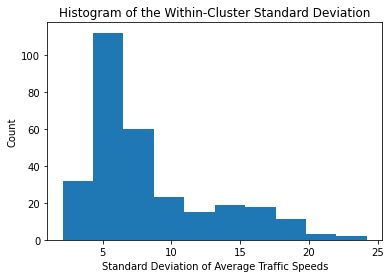

In [24]:
speed_variance_by_tract = speeds_by_tract.var()["speed_mph_mean"]
average_variance_by_tract = speeds_by_tract.std()["speed_mph_mean"].mean()
variance_average_by_tract = speeds_by_tract.mean()["speed_mph_mean"].std()

data = speeds_by_tract.std()['speed_mph_mean']

plt.hist(data)
plt.ylabel('Count')
plt.xlabel('Standard Deviation of Average Traffic Speeds')
plt.title('Histogram of the Within-Cluster Standard Deviation')

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1civ3
points: 3
-->

In [25]:
speed_variance_by_tract

DISPLAY_NAME
0 16th Avenue, Hayward Park, San Mateo               74.216606
0 Avoca Alley, West of Twin Peaks, San Francisco     27.750154
0 Bass Court, Bayview, San Francisco                 17.557393
0 Berkeley Way, Diamond Heights, San Francisco       61.383303
0 Bernard Street, Nob Hill, San Francisco            12.712794
                                                       ...    
Old Guadalupe Trail, Daly City                      111.530423
Old Sled Trail, Bolinas                             224.149560
Petrolite Street, Richmond                          341.283815
Regatta Boulevard, Marina Bay, Richmond             374.089802
West Point Road, Bayview, San Francisco              73.804147
Name: speed_mph_mean, Length: 295, dtype: float64

In [26]:
grader.check("q1civ3")

q1civ3 results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.d. What would be the ideal spatial clustering?

This is an active research problem in many spatiotemporal modeling communities, and there is no single agreed-upon answer. Answer both of the following specifically knowing that you'll need to analyze traffic patterns according to this spatial clustering:

1. **What is a good metric for a spatial structure?** How do we define good? Bad? What information do we expect a spatial structure to yield? Use the above parts and questions to help answer this.
2. **What would you do to optimize your own metric for success in a spatial structure?**

See related articles:

- Uber's H3 [link](https://eng.uber.com/h3/), which divides the world into hexagons
- Traffic Analysis Zones (TAZ) [link](https://en.wikipedia.org/wiki/Traffic_analysis_zone), which takes census data and additionally accounts for vehicles per household when dividing space

<!--
BEGIN QUESTION
name: q1d
points: 3
manual: True
-->

_1. Uber's H3 Hexagonal Hierarchical spatial indexing was based around the idea that people are always in motion and in order to capture that motion to efficiently optimize ride pricing and dispatch, and to visualize and explore spatial data we need to minimize the quantization error introduced when users move through a city. A 'good metric for spatial structuring' has been defined as one that gives the most accurate socio-economic data. We expect a spatial structure to yield many things including: the size of the individual bin (or in Uber's case, hexagon) in relation to the size of the greater surrounding area (ie block as part of a city), the population within that bin, and the speed of the traffic within that bin. A spatial structure that can do these tasks accurately is typically defined as 'good'._

_2. Our metric for success is primarily based upon accurately predicting traffic speed in each bin, as a part of the greater surrounding area. So similar to the approach that Uber has taken, we are also looking to minimize the quantization error introduced when users move through a city. To effectively achieve this goal we have binned the world into squares based on latitude and longitude degrees. As the bins get smaller there is greater computations required but the traffic predictions do reduce in average variance._

<!-- END QUESTION -->



# Step 2 - Guided EDA: Understanding COVID Lockdown Impact on Traffic

In this step, we'll examine the impact of COVID on traffic. In particular, we'll study 3 different questions:

- How did lockdown affect traffic speed? What factors dictate how much lockdown affected traffic speed?
- What areas of traffic were most impacted by lockdown?

## 2.a. How did lockdown affect traffic speed?

<!-- BEGIN QUESTION -->

### 2.a.i. Sort census tracts by average speed, pre-lockdown.

Consider the pre-lockdown period to be March 1 - 13, before the first COVID-related restrictions (travel bans) were announced on March 14, 2020.

1. **Report a DataFrame which includes the *names* of the 10 census tracts with the lowest average speed**, along with the average speed for each tract.
2. **Report a DataFrame which includes the *names* of the 10 census tracts with the highest average speed**, along with the average speed for each tract.
2. Do these names match your expectations for low speed or high speed traffic pre-lockdown?  What relationships do you notice? (What do the low-speed areas have in common? The high-speed areas?) For this specific question, answer qualitatively. No need to quantify. **Hint**: Look up some of the names on a map, to understand where they are.
3. **Plot a histogram for all average speeds, pre-lockdown**.
4. You will notice a long tail distribution of high speed traffic. What do you think this corresponds to in San Francisco? Write down your hypothesis.

Hint: To start off, think about what joins may be useful to get the desired DataFrame.

<!--
BEGIN QUESTION
name: q2ai1
points: 3
manual: True
-->

_For the top 10 lowest average census tracts speeds, I would have to assume that they would all be in the heart of San Francisco as that is the most densely populated and heavy traffic sites in the county, thus these spots would have low average traffic speeds. Whereas for the top 10 highest average census tracts speeds, I would have to assume that they would be on the edge of the city, the farthest points from the center of the city since those places are less densely populated and have on average less traffic, thus the average traffic speeds would be higher. As for the tail, I think that there would likely be a right tail of high traffic speed points that would be represented by these areas on the edge of the city or on the less packed freeways far from the city center._

<!-- END QUESTION -->

Answer the following question:
<!--
BEGIN QUESTION
name: q2ai2
points: 3
-->

In [27]:
# compute the average speed per census tract (will use this later),
# BEFORE the shelter-in-place was announced on March 14, 2020.
# Autograder expects this to be a series
base = speeds_to_tract[speeds_to_tract["day"] < 14]
averages_pre =  base.groupby("MOVEMENT_ID").agg(np.mean)["speed_mph_mean"].to_frame().reset_index()
# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
averages_pre_named = averages_pre.merge(tract_to_gps, how = "inner", left_on ="MOVEMENT_ID", right_on = "MOVEMENT_ID").set_index("MOVEMENT_ID")
averages_pre = averages_pre_named["speed_mph_mean"]
averages_pre_named

,speed_mph_mean,DISPLAY_NAME,geometry
MOVEMENT_ID,,,
9,14.585102,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150..."
20,15.679922,"900 Sutter Street, Lower Nob Hill, San Francisco","MULTIPOLYGON (((-122.42208 37.78847, -122.4153..."
21,14.292445,"3400 Pierce Street, Marina District, San Franc...","MULTIPOLYGON (((-122.44191 37.80374, -122.4371..."
44,23.353083,"1700 Egbert Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.40211 37.72779, -122.3998..."
78,16.213552,"1400 Thomas Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.39270 37.72928, -122.3918..."
...,...,...,...
2691,20.746333,"800 Hacienda Way, Millbrae","MULTIPOLYGON (((-122.42288 37.60714, -122.4187..."
2694,17.042386,"1900 Buchanan Street, Western Addition, San Fr...","MULTIPOLYGON (((-122.43549 37.78870, -122.4338..."
2695,20.029011,"2200 Rivera Street, Sunset District, San Franc...","MULTIPOLYGON (((-122.49505 37.74968, -122.4858..."


In [28]:
grader.check("q2ai2")

q2ai2 results: All test cases passed!

Report the lowest 10 census tracts with the lowest average speed
Remember we want the NAME of each census tract too. For the autograder, please keep the name of the speed field, `speed_mph_mean`.

<!--
BEGIN QUESTION
name: q2ai3
points: 1
-->

In [29]:
bottom10_averages_pre = averages_pre_named.nsmallest(10, "speed_mph_mean")
bottom10_averages_pre

,speed_mph_mean,DISPLAY_NAME,geometry
MOVEMENT_ID,,,
1691,12.417079,"200 O'Farrell Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41462 37.78558, -122.4129..."
2340,12.595120,"0 Mason Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41405 37.78279, -122.4107..."
1688,12.945291,"1100 Taylor Street, Nob Hill, San Francisco","MULTIPOLYGON (((-122.41629 37.79389, -122.4152..."
651,13.195865,"2900 22nd Street, Mission District, San Francisco","MULTIPOLYGON (((-122.41672 37.75717, -122.4123..."
643,13.490311,"200 Myrtle Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.42146 37.78663, -122.4182..."
1689,13.502505,"200 Sutter Street, Financial District, San Fra...","MULTIPOLYGON (((-122.40879 37.79016, -122.4071..."
1244,13.549474,"800 Jackson Street, Chinatown, San Francisco","MULTIPOLYGON (((-122.41172 37.79629, -122.4084..."
1245,13.570625,"500 Geary Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41500 37.78745, -122.4133..."
644,13.626251,"200 Jones Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41443 37.78466, -122.4127..."


In [30]:
grader.check("q2ai3")

q2ai3 results: All test cases passed!

Report the highest 10 census tracts with the highest average speed.

<!--
BEGIN QUESTION
name: q2ai4
points: 1
-->

In [31]:
top10_averages_pre = averages_pre_named.nlargest(10, "speed_mph_mean")
top10_averages_pre

,speed_mph_mean,DISPLAY_NAME,geometry
MOVEMENT_ID,,,
285,59.498552,"1600 Maritime Street, Oakland","MULTIPOLYGON (((-122.33037 37.82058, -122.3161..."
495,53.867847,"4200 Shelter Creek Lane, San Bruno","MULTIPOLYGON (((-122.43101 37.61999, -122.4300..."
1653,47.318340,"Petrolite Street, Richmond","MULTIPOLYGON (((-122.42976 37.96540, -122.4185..."
2339,47.225137,"Frenchmans Creek Road, Half Moon Bay","MULTIPOLYGON (((-122.46816 37.56079, -122.4605..."
1744,45.492292,"1200 Helen Drive, Millbrae","MULTIPOLYGON (((-122.42820 37.60497, -122.4263..."
2244,44.304919,"0 Crystal Springs Terrace, Hillsborough Park, ...","MULTIPOLYGON (((-122.37189 37.54776, -122.3710..."
2660,43.848188,"0 Burgess Court, Sausalito","MULTIPOLYGON (((-122.52032 37.87046, -122.5193..."
1955,42.784267,"Liccicitos Road, Moss Beach","MULTIPOLYGON (((-122.52036 37.57534, -122.5180..."
1732,40.587037,"0 Longview Drive, Westlake, Daly City","MULTIPOLYGON (((-122.50053 37.70083, -122.4961..."


In [32]:
grader.check("q2ai4")

q2ai4 results: All test cases passed!

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2ai5
points: 1
manual: True
-->

Text(0, 0.5, 'count within the avg speed range')

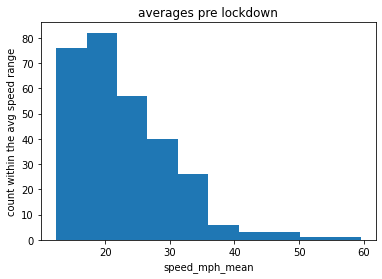

In [33]:
plt.title("averages pre lockdown")
plt.hist(averages_pre)
plt.xlabel("speed_mph_mean")
plt.ylabel("count within the avg speed range")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.ii. Sort census tracts by average speed, post-lockdown.

I suggest checking the top 10 and bottom 10 tracts by average speed, post-lockdown. Consider the post-lockdown period to be March 14 - 31, after the first COVID restrictions were established on March 14, 2020. It's a healthy sanity check. For this question, you should report:

- **Plot a histogram for all average speeds, post-lockdown.**
- **What are the major differences between this post-lockdown histogram relative to the pre-lockdown histogram above**? Anything surprising? What did you expect, and what did you find?

Write the written answers in the cell below, and the coding answers in the cells after that.

<!--
BEGIN QUESTION
name: q2aii1
points: 1
manual: True
-->

_The major differences between this post-lockdown histogram relative to the pre-lockdown histogram are the exact differences that we would expect: a higher distribution of faster traffic speeds in the San Francisco area, but no changes that are extraordinary outstanding since the city still is confined to small intricate blocks with many stop signs and street lights. Post-lockdown there are many fewer people on the roads and thus we would expect traffic speeds to be increased by the decrease in cars and congestion; and comparing the two histograms that is indeed what we can observe._

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q2aii2
points: 2
-->

In [34]:
# compute the average speed per census tract (will use this later),
# AFTER (and including) the first COVID restrictions were put into effect.
# Autograder expects this to be a series
base_post = speeds_to_tract[speeds_to_tract["day"] >= 14]
averages_post = base_post.groupby("MOVEMENT_ID").agg(np.mean)["speed_mph_mean"].to_frame().reset_index()
# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
averages_post_named = averages_post.merge(tract_to_gps, how = "inner", left_on= "MOVEMENT_ID", right_on = "MOVEMENT_ID").set_index("MOVEMENT_ID")
averages_post = averages_post_named["speed_mph_mean"]
averages_post_named

,speed_mph_mean,DISPLAY_NAME,geometry
MOVEMENT_ID,,,
9,16.143154,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150..."
20,16.871488,"900 Sutter Street, Lower Nob Hill, San Francisco","MULTIPOLYGON (((-122.42208 37.78847, -122.4153..."
21,15.754795,"3400 Pierce Street, Marina District, San Franc...","MULTIPOLYGON (((-122.44191 37.80374, -122.4371..."
44,25.956602,"1700 Egbert Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.40211 37.72779, -122.3998..."
78,16.476000,"1400 Thomas Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.39270 37.72928, -122.3918..."
...,...,...,...
2691,17.917000,"800 Hacienda Way, Millbrae","MULTIPOLYGON (((-122.42288 37.60714, -122.4187..."
2694,22.128519,"1900 Buchanan Street, Western Addition, San Fr...","MULTIPOLYGON (((-122.43549 37.78870, -122.4338..."
2695,23.440404,"2200 Rivera Street, Sunset District, San Franc...","MULTIPOLYGON (((-122.49505 37.74968, -122.4858..."


In [35]:
grader.check("q2aii2")

q2aii2 results: All test cases passed!

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2aii3
points: 1
manual: True
-->

Text(0, 0.5, 'count within the avg speed range')

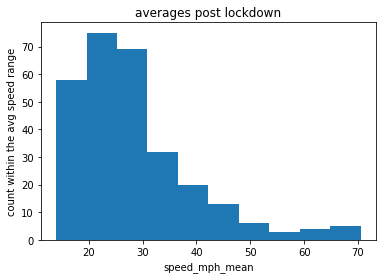

In [36]:
plt.hist(averages_post)
plt.title("averages post lockdown")
plt.xlabel("speed_mph_mean")
plt.ylabel("count within the avg speed range")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iii. Sort census tracts by change in traffic speed from pre to post lockdown.

For each segment, compute the difference between the pre-lockdown average speed (March 1 - 13) and the post-lockdown average speed (March 14 - 31). **Plot a histogram of all differences.** Sanity check that the below histogram matches your observations of the histograms above, on your own.

<!--
BEGIN QUESTION
name: q2aiii
points: 2
manual: True
-->

Text(0, 0.5, 'count within the avg speed range')

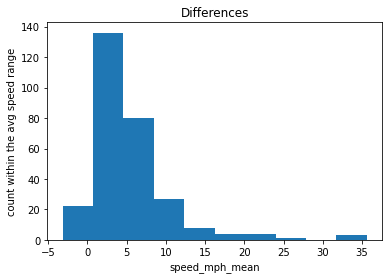

In [37]:
# The autograder expects differences to be a series object with index
# MOVEMENT_ID.
differences = averages_post - averages_pre
# plot the differences
plt.hist(differences)
plt.title("Differences")
plt.xlabel("speed_mph_mean")
plt.ylabel("count within the avg speed range")

In [38]:
grader.check("q2aiii")

q2aiii results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iv. Quantify the impact of lockdown on average speeds.

1. **Plot the average speed by day, across all segments**. Be careful not to plot the average of census tract averages instead. Recall the definition of segments from Q1.
2. Is the change in speed smooth and gradually increasing? Or increasing sharply? Why? Use your real-world knowledge of announcements and measures during that time, in your explanation. You can use this list of bay area COVID-related dataes: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/

<!--
BEGIN QUESTION
name: q2aiv1
points: 1
manual: True
-->

In [39]:
# Autograder expects this to be a series object containing the
# data for your line plot -- average speeds per day.
speeds_daily = speeds_to_tract.groupby("day").agg(np.mean)["speed_mph_mean"]
speeds_daily

day
1     23.633128
2     22.324856
3     21.826422
4     21.931746
5     21.985687
6     22.100850
7     22.851309
8     24.049457
9     23.008859
10    22.661657
11    22.776953
12    23.078484
13    23.320432
14    24.177464
15    25.698629
16    24.771821
17    28.912335
18    28.811352
19    29.502508
20    28.939733
21    30.062931
22    30.766490
23    30.236890
24    30.120710
25    30.251735
26    30.136657
27    30.344251
28    30.489458
29    31.062707
30    30.440111
31    30.870653
Name: speed_mph_mean, dtype: float64

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Write your written answer in the cell below

<!--
BEGIN QUESTION
name: q2aiv2
points: 1
manual: True
-->

_The change in speed is gradually increasing; for the first two weeks, the speeds mostly stayed the same but by the third week we see a consistent gradual increase. In the first week we can actually observe an decrease in traffic speed likely because most people were still going into work, living their normal lives, and also because there was some panic from people who thought the world was going to end and they needed to stockpile, like those who desperately needed toilet paper. For these reasons we can see a slight decrease in traffic speed during the first week, and in the second week we see an increase to around the average speed pre-lockdown, likely because people have stopped going out as much but are still fearful and going out to prepare for a long lockdown. Finally after the first two weeks the gradual increase begins and people no longer need to stockpile and have made the adjustment to working from home._

<!-- END QUESTION -->

Ignore the empty cell below, just run the autograder to test the code above is correct.
<!--
BEGIN QUESTION
name: q2aiv3
points: 1
-->

Text(0, 0.5, 'day')

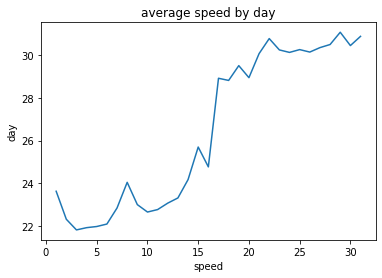

In [40]:
plt.plot(speeds_daily )
plt.title("average speed by day")
plt.xlabel("speed")
plt.ylabel("day")

In [41]:
grader.check("q2aiv3")

q2aiv3 results: All test cases passed!

<!-- BEGIN QUESTION -->

### 2.a.v. Quantify the impact of pre-lockdown average speed on change in speed.

1. Compute the correlation between change in speed and the *pre*-lockdown average speeds. Do we expect a positive or negative correlation, given our analysis above?
2. Compute the correlation between change in speed and the post-lockdown average speeds.
3. **How does the correlation in Q1 compare with the correlation in Q2?** You should expect a significant change in correlation value. What insight does this provide about traffic?

Written answers in the first cell, coding answerts in the following cell.

<!--
BEGIN QUESTION
name: q2av1
points: 2
manual: True
-->

_The correlation post-lockdown had a much stronger positive linear relationship when compared to correlation pre-lockdown. We observed that the correlation difference pre-lockdown had a coefficient of 0.46 whereas the correlation difference post-lockdown had a coefficient of 0.79, representing a stronger positive linear association. This insight allows us to predict that traffic will be more affected post-lockdown by other large changes in society. Therefore there will be more change in speeds going forward in our post-lockdown society and thus traffic speeds will likely decrease as a result of increasing changes in speeds (greater fluctuation of traffic speed often results in more traffic, or slower traffic speeds overall)._

<!-- END QUESTION -->


<!--
BEGIN QUESTION
name: q2av2
points: 2
-->

In [42]:
diff_na = differences.isna()

averages_pre = averages_pre[~diff_na] 
differences = differences[~diff_na] 
# averages_pre
corr_pre_diff = np.corrcoef(differences, averages_pre)[0][0]
corr_post_diff = np.corrcoef(differences, averages_post)[0][1]
corr_pre_diff = differences.corr(averages_pre)
corr_pre_diff * corr_post_diff
# merged_pre_post

0.36724914907071704

In [43]:
grader.check("q2av2")

q2av2 results: All test cases passed!

## 2.b. What traffic areas were impacted by lockdown?

<!-- BEGIN QUESTION -->

### 2.b.i. Visualize spatial heatmap of average traffic speed per census tract, pre-lockdown.

Visualize a spatial heatmap of the grouped average daily speeds per census tract, which you computed in previous parts. Use the geopandas [chloropleth maps](https://geopandas.org/docs/user_guide/mapping.html#choropleth-maps). **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest**. These may be a local extrema, or a region that is strangely all similar.

**Hint**: Use [`to_crs`](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.to_crs.html) and make sure the `epsg` is using the Pseudo-Mercator projection.

**Hint**: You can use `contextily` to superimpose your chloropleth map on a real geographic map.

**Hint** You can set a lower opacity for your chloropleth map, to see what's underneath, but be aware that if you plot with too low of an opacity, the map underneath will perturb your chloropleth and meddle with your conclusions.

Written answers in the first cell, coding answers in the second cell.

<!--
BEGIN QUESTION
name: q2bi1
points: 1
manual: True
-->

_-Local extrema in the heart of the city of San Francisco near Embarcadero_

_-Local extrema in north bay on the northeast section of mill valley_

_-The only section that is yellow is the southwest section of Emeryville near the Bay Bridge exit/entrance, likely means that this area is very traffic dependent on time of day_

_-Local extrema near San Mateo_

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bi2
points: 4
manual: True
-->

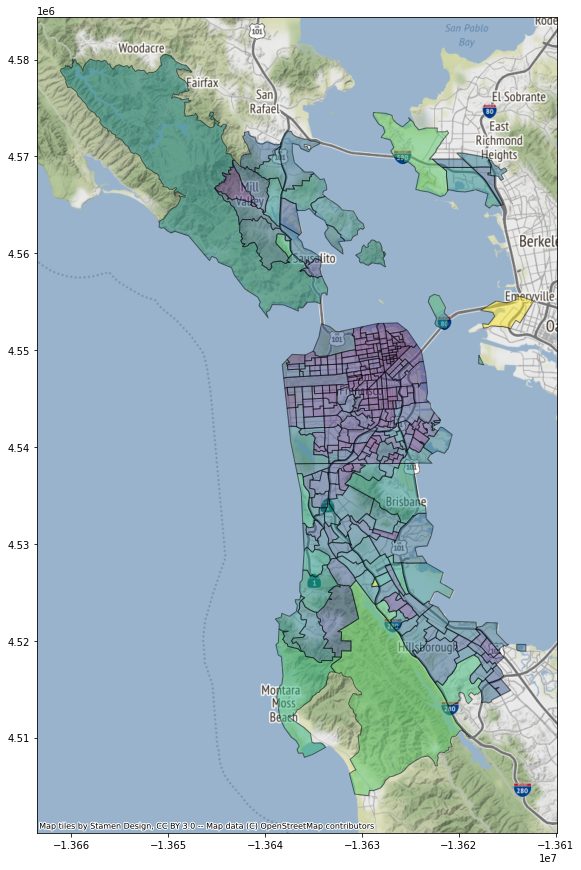

In [44]:
gpd_pre = gpd.GeoDataFrame(averages_pre_named)
ax = gpd_pre.to_crs(3857).plot(column = "speed_mph_mean", figsize=(15, 15),alpha=0.5, edgecolor = 'k')
cx.add_basemap(ax)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.b.ii. Visualize change in average daily speeds pre vs. post lockdown.

Visualize a spatial heatmap of the census tract differences in average speeds, that we computed in a previous part. **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest.** Some possible ideas for interesting notes: Which areas saw the most change in average speed? Which areas weren't affected? Why did some areas see *reduced* average speed?

First cell is for the written answers, second cell is for the coding answers.

<!--
BEGIN QUESTION
name: q2bii1
points: 1
manual: True
-->

_-The west coastal region near Montara Moss beach saw a large change in average speed. It is likely that many of the wealthy people from San Francisco retired to their second homes, or away from their city apartments, to the beach to get away from densely populated areas._

_-Similarly with Mill Valley and south San Rafael, there was a large change in average speed because people wanted to get out of the dense city of SF and away from people._

_-Southwest Emeryville as well changed from yellow to purple, representing that there was also a large change in traffic speed, likely again people moving away from the two major cities it lies between._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bii2
points: 4
manual: True
-->

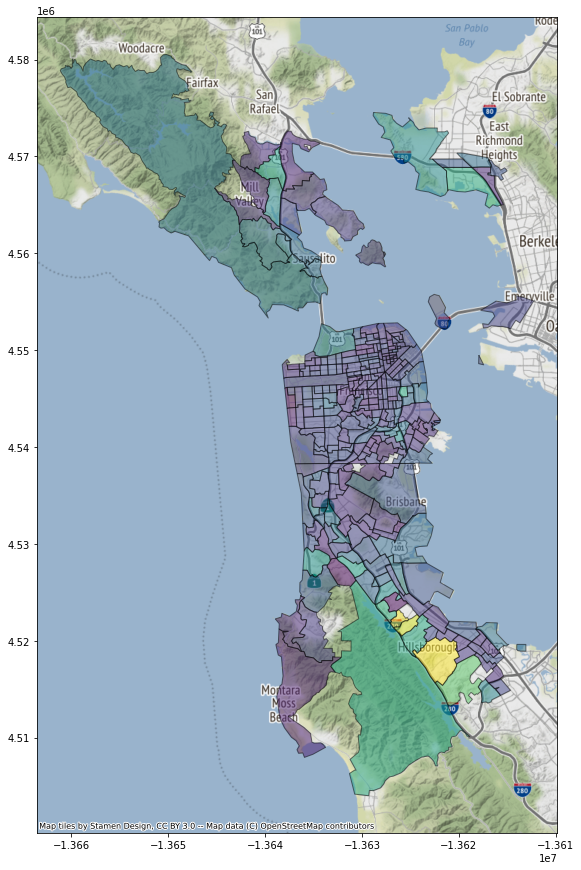

In [45]:
averages_pre_named["difference_mpg_means"] = differences
gpd_diff = gpd.GeoDataFrame(averages_pre_named)
ax_diff = gpd_pre.to_crs(3857).plot(column = "difference_mpg_means",figsize=(15, 15), alpha=0.5, edgecolor = 'k')
cx.add_basemap(ax_diff)

<!-- END QUESTION -->



# Step 3 - Open-Ended EDA: Understanding lockdown impact on travel times

Explore daily travel times from Hayes Valley to other destinations both before and throughout lockdown. Use the following questions as suggestions for what to explore, temporally and spatially:

- How did lockdown affect travel times? Are there any meaningful factors that determined how travel time would be impacted? How was travel time affected over time?
- Travel to which destinations were affected by lockdown? Are there surprisingly disproportionate amounts of impact in certain areas?

## 3.a. Load Datasets

In this step, we will load two datasets:

- Daily travel times from Hayes Valley to all other census tracts around San Francisco.
- Daily travel times from 300 Hayes St to Golden Gate Park in San Francisco.

For this specific set of data, we can ask several more questions; which questions you pursue are up to you, including any that you come up that are not on this list:

- Which routes from Hayes Valley had similar impact on travel time? Did they share any factors in common? Traveling through the same place -- e.g., a freway? Traveling in similar areas e.g., residential areas?
- Were clusters of routes impacted more severely than others over time? What determined the degree of impact?

In [46]:
PATH_TIMES = 'data/travel-times-daily-san-francisco-2020-3.csv'
times_to_tract = pd.read_csv(PATH_TIMES)
times_to_tract

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day
0,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",322,211,489,1
1,1277,"300 Hayes Street, Civic Center, San Francisco",20,"900 Sutter Street, Lower Nob Hill, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",291,179,470,1
2,1277,"300 Hayes Street, Civic Center, San Francisco",21,"3400 Pierce Street, Marina District, San Franc...","3/1/2020 - 3/1/2020, Every day, Daily Average",635,438,920,1
3,1277,"300 Hayes Street, Civic Center, San Francisco",44,"1700 Egbert Avenue, Bayview, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",786,566,1090,1
4,1277,"300 Hayes Street, Civic Center, San Francisco",46,"500 Chester Street, West Oakland, Oakland","3/1/2020 - 3/1/2020, Every day, Daily Average",891,682,1162,1
...,...,...,...,...,...,...,...,...,...
10333,1277,"300 Hayes Street, Civic Center, San Francisco",2624,"1300 16th Avenue, Inner Sunset, San Francisco","3/31/2020 - 3/31/2020, Every day, Daily Average",502,411,611,31
10334,1277,"300 Hayes Street, Civic Center, San Francisco",2643,"1300 Egbert Avenue, Bayview, San Francisco","3/31/2020 - 3/31/2020, Every day, Daily Average",571,475,685,31
10335,1277,"300 Hayes Street, Civic Center, San Francisco",2673,"100 Rutledge Street, Bernal Heights, San Franc...","3/31/2020 - 3/31/2020, Every day, Daily Average",367,265,507,31
10336,1277,"300 Hayes Street, Civic Center, San Francisco",2694,"1900 Buchanan Street, Western Addition, San Fr...","3/31/2020 - 3/31/2020, Every day, Daily Average",222,167,294,31


# Step 4 - Guided Modeling: Predict traffic speed post-lockdown

In this step, you'll train a model to predict traffic speed. In particular, you'll learn how to provide implicit supervision and correction to your model, when you know there's been a distribution shift in its data, leading to a large gap between train and test sets. You'll follow the following outline:

- Build a model to predict daily traffic speed in San Francisco. Train and evaluate on *pre*-lockdown traffic speeds around the city.
- Evaluate your model on post-lockdown traffic speeds. Where is your model most mistaken, and why?
- Using this knowledge, how would you correct your model for a more accurate post-lockdown traffic predictor?


The technical term for a phenomenon like the lockdown, which caused major distributional shifts in the data, is *change point*. A large body of work studies "change point detection," but you'll be harder pressed to find a "handling change point" paper. 

## 4.a. Predict daily traffic speed on pre-lockdown data

For your model, you will predict daily traffic speed per census tract, given the previous $k=5$ daily traffic speeds for that census tract. In particular, say a matrix $A$ is $n \times d$, where $n$ is the number of census tracts and $d$ is the number of days. We define the following inputs and labels:

$$X_{(i,t)} = [A_{(i,t-5)}, A_{(i,t-4)}, A_{(i,t-3)}, A_{(i,t-2)}, A_{(i,t-1)}]$$
$$y_{(i,t)} = [A_{(i,t)}]$$

This just means that each sample $X_i$ includes speed averages from the previous 5 days for the $i$th census track.

### 4.a.i. Assemble dataset to predict daily traffic speed.

Below, we've included skeletons for the helper functions we defined, to complete the problem. We highly recommend following this skeleton code, else we cannot guarantee staff support for debugging your work.


**Hint**: What's wrong with collecting all samples, then randomly selecting some percentage to hold out? See the answer in the expandable below.

<details>
    <summary>[Click to expand] How to do train-validation split correctly, on time series</summary>
    
For a *time series* in particular, this random split would be cheating, because data within each day is highly correlated. Instead, you should hold out entire days from the dataset. In this case, you should hold out the last 2 days for your validation set.
</details>

<!--
BEGIN QUESTION
name: q4ai1
points: 1
-->

In [47]:
def dataframe_to_time_series(df: pd.DataFrame):
    """Convert your dataframe into a 'time series'.
    
    :param df: the original dataframe, mapping speeds to census tracts.
        This dataframe should contain the `MOVEMENT_ID` (census tract id),
        `day`, and average speed for that day `speed_mph_mean`
    :return: a new dataframe that is formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    """
    new_df = df.loc[:, ["MOVEMENT_ID", "day", "speed_mph_mean"]]
    return pd.pivot_table(new_df, columns = 'day', values = "speed_mph_mean" , index = "MOVEMENT_ID")

time_series = dataframe_to_time_series(speeds_to_tract)
time_series_pre = time_series.iloc[:, list(range(13))]
time_series

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
MOVEMENT_ID,,,,,,,,,,,,,,,,,,,,,
9,16.196918,14.395121,13.868696,14.225414,14.312199,13.811991,15.508637,16.210738,14.845320,14.711534,...,15.880078,17.019573,15.527393,15.925605,15.959744,17.317841,17.845053,17.839214,15.743376,15.797248
20,17.418045,15.460956,15.463297,15.419764,15.291956,15.227310,17.088325,18.088862,16.178105,15.295494,...,18.843376,17.029943,16.286795,17.007889,15.205696,17.461643,16.997424,19.024721,14.134949,17.287814
21,15.141171,13.176998,13.781490,14.052113,14.078134,13.636357,13.958269,14.642295,15.616215,14.850471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,25.079544,23.492586,22.727711,22.274143,21.874703,23.082414,22.875819,25.653848,23.501387,22.739869,...,24.381933,25.350188,31.126033,NaN,22.518500,27.697570,26.899667,19.777429,24.385409,24.683422
78,16.174464,16.755496,16.039120,16.118401,15.665069,15.797723,15.302616,19.284080,16.253357,16.131290,...,NaN,NaN,15.690000,NaN,NaN,16.849000,NaN,NaN,16.493000,16.767400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,18.600000,17.787000,23.473000,NaN,19.038000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2694,17.809761,16.725889,16.530783,16.446517,16.503053,16.652473,17.427329,18.057287,17.310272,16.998730,...,23.886576,23.410192,23.302396,23.031966,23.107702,23.581885,24.382866,23.278001,23.426889,24.056357
2695,20.106061,20.228850,19.849135,20.145877,22.357605,19.250479,19.223717,19.471282,20.497077,20.401085,...,29.218800,NaN,NaN,NaN,23.396500,NaN,19.708000,26.461900,NaN,19.959500


In [48]:
grader.check("q4ai1")

q4ai1 results: All test cases passed!

In [49]:
def time_series_to_numpy(df: pd.DataFrame, T: int, n_val: int):
    """Convert your 'time series' into train-validate splits, in numpy
    
    You can assume your dataframe contains a day column where days
    start from 1 and are consecutive.
    
    :param df: the dataframe formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    :param T: number of days to include in each training sample
    :param n_val: number of days to hold out for the validation set.
    
        Say we have 5 total days in our dataset, T=2, n_val=2. This means
        during training, we have samples that pull averages from days 1 and
        2 to predict day 3: x=(1, 2), y=(3,) 
        
        For validation, we have samples
        like x=(2, 3), y=(4,) and x=(3, 4), y=(5,). This way, the model sees
        data from days 4 and 5 only during validation.
    :return: Set of 4 numpy arrays - X_train, y_train, X_val, y_val - where
        X_* arrays are (n, T) and y_* arrays are (n,).
    """
    def sample(this_df, size):
        new_df = pd.DataFrame()
        for row in np.arange(size):
            new_df = new_df.append(this_df.shift(-row, axis = 1).iloc[:, :T+1])
        return new_df
    
    num_of_days = df.shape[1]
    training, validation = df.iloc[:, : num_of_days - n_val], df.iloc[:, num_of_days - n_val - T: num_of_days]
    
    training_sample = sample(training, num_of_days - T - n_val)
    validation_sample = sample(validation, n_val)
    
    X_train, y_train = np.array(training_sample.iloc[:, :-1]), np.array(training_sample.iloc[:, -1:].unstack())
    X_val, y_val = np.array(validation_sample.iloc[:, :-1]), np.array(validation_sample.iloc[:, -1:].unstack())
    
    return X_train, y_train, X_val, y_val

def remove_nans(X: np.array, y: np.array):
    """Remove all nans from the provided (X, y) pair.
    
    Note: A nan in X means that sample must be removed from *both X and y.
        Likewise, a nan in y means that sample must be removed from *both
        X and y.
    
    :param X: (n, T) array of model inputs
    :param y: (n,) array of labels
    :return: (X, y)
    """
    if not len(X):
        return X, y
    x_and_y = ~np.logical_or((np.isnan(X).any(axis = 1)), np.isnan(y))
    return X[x_and_y], y[x_and_y]
    

answer = time_series_to_numpy(time_series, 10, 2)
answer2 = remove_nans(answer[0], answer[1])
answer2[0].shape

(4355, 10)

In [50]:
grader.check("q4ai2")

q4ai2 results: All test cases passed!

In [51]:
def time_series_to_dataset(time_series: pd.DataFrame, T: int, n_val: int):
    """Convert 'time series' dataframe to a numpy dataset.
    
    Uses utilites above time_series_to_numpy and remove_nans
    
    For description of arguments, see time_series_to_numpy docstring.
    """
    
    to_numpy = time_series_to_numpy(time_series, T, n_val)
    removed_na_x_y_train = remove_nans(to_numpy[0], to_numpy[1]) # X_train, y_train
    removed_na_x_y_val = remove_nans(to_numpy[2], to_numpy[3])  # X_val, y_val
    
    
    return removed_na_x_y_train[0], removed_na_x_y_train[1], removed_na_x_y_val[0], removed_na_x_y_val[1]
    
X_train, y_train, X_val, y_val = time_series_to_dataset(time_series_pre, 5, 2)

In [52]:
grader.check("q4ai3")

q4ai3 results: All test cases passed!

In [53]:
time_series

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
MOVEMENT_ID,,,,,,,,,,,,,,,,,,,,,
9,16.196918,14.395121,13.868696,14.225414,14.312199,13.811991,15.508637,16.210738,14.845320,14.711534,...,15.880078,17.019573,15.527393,15.925605,15.959744,17.317841,17.845053,17.839214,15.743376,15.797248
20,17.418045,15.460956,15.463297,15.419764,15.291956,15.227310,17.088325,18.088862,16.178105,15.295494,...,18.843376,17.029943,16.286795,17.007889,15.205696,17.461643,16.997424,19.024721,14.134949,17.287814
21,15.141171,13.176998,13.781490,14.052113,14.078134,13.636357,13.958269,14.642295,15.616215,14.850471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,25.079544,23.492586,22.727711,22.274143,21.874703,23.082414,22.875819,25.653848,23.501387,22.739869,...,24.381933,25.350188,31.126033,NaN,22.518500,27.697570,26.899667,19.777429,24.385409,24.683422
78,16.174464,16.755496,16.039120,16.118401,15.665069,15.797723,15.302616,19.284080,16.253357,16.131290,...,NaN,NaN,15.690000,NaN,NaN,16.849000,NaN,NaN,16.493000,16.767400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,18.600000,17.787000,23.473000,NaN,19.038000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2694,17.809761,16.725889,16.530783,16.446517,16.503053,16.652473,17.427329,18.057287,17.310272,16.998730,...,23.886576,23.410192,23.302396,23.031966,23.107702,23.581885,24.382866,23.278001,23.426889,24.056357
2695,20.106061,20.228850,19.849135,20.145877,22.357605,19.250479,19.223717,19.471282,20.497077,20.401085,...,29.218800,NaN,NaN,NaN,23.396500,NaN,19.708000,26.461900,NaN,19.959500


In [54]:
time_series_pre

day,1,2,3,4,5,6,7,8,9,10,11,12,13
MOVEMENT_ID,,,,,,,,,,,,,
9,16.196918,14.395121,13.868696,14.225414,14.312199,13.811991,15.508637,16.210738,14.845320,14.711534,13.739901,14.391436,13.955833
20,17.418045,15.460956,15.463297,15.419764,15.291956,15.227310,17.088325,18.088862,16.178105,15.295494,14.637109,14.282602,14.437358
21,15.141171,13.176998,13.781490,14.052113,14.078134,13.636357,13.958269,14.642295,15.616215,14.850471,13.790100,14.573349,15.177251
44,25.079544,23.492586,22.727711,22.274143,21.874703,23.082414,22.875819,25.653848,23.501387,22.739869,23.756560,24.989269,23.176275
78,16.174464,16.755496,16.039120,16.118401,15.665069,15.797723,15.302616,19.284080,16.253357,16.131290,15.773117,16.091415,16.208158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,18.600000,17.787000,23.473000,NaN,19.038000,NaN,NaN,22.107000,NaN
2694,17.809761,16.725889,16.530783,16.446517,16.503053,16.652473,17.427329,18.057287,17.310272,16.998730,16.891788,17.008323,17.559142
2695,20.106061,20.228850,19.849135,20.145877,22.357605,19.250479,19.223717,19.471282,20.497077,20.401085,23.870537,20.215396,20.343131


In [55]:
(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

((1705, 5), (1705,), (562, 5), (562,))

<!-- BEGIN QUESTION -->

### 4.a.ii. Train and evaluate linear model on pre-lockdown data.

1. **Train a linear model that forecasts the next day's speed average** using your training dataset `X_train`, `y_train`. Specifically, predict $y_{(i,t)}$ from $X_{(i,t)}$, where
- $y_{(i,t)}$ is the daily speed average for day $t$ and census tract $i$
- $X_{(i,t)}$ is a vector of daily speed averages for days $t-5,t-4,t-3,t-2,t-1$ for census tract $i$
2. **Evaluate your model** on your validation dataset `X_val`, `y_val`.
3. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

Our model is quantitatively and qualitatively pretty accurate at this point, training and evaluating on pre-lockdown data.

<!--
BEGIN QUESTION
name: q4aii1
points: 1
manual: True
-->

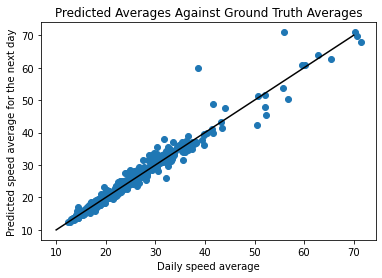

In [56]:
reg = LinearRegression().fit(X_train,y_train) # set to trained linear model
score = reg.score(X_val, y_val) # report r^2 score

# create the scatter plot below
# plt.scatter(X_train, y_train)

y_val_pred = reg.predict(X_val)
plt.title("Predicted Averages Against Ground Truth Averages")
plt.scatter(y_val, y_val_pred)
plt.xlabel('Daily speed average')
plt.ylabel("Predicted speed average for the next day")
plt.plot([10,70] , [10,70], 'k', alpha = 0.99)

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4aii2
points: 1
-->

In [57]:
score

0.9639232922122069

In [58]:
grader.check("q4aii2")

q4aii2 results: All test cases passed!

## 4.b. Understand failures on post-lockdown data

Your dataset is distributed spatially and temporally. As a result, the most intuitive spaces to visualize your model error or performance along is both spatially and temporally. In this step, we focus on understanding *where* your model fails.

### 4.b.i. Evaluate on post-lockdown data

1. Using your previously trained linear regression model `reg`, **evaluate on post-lockdown data**, meaning daily speed averages on March 14, 2020. Evaluate on all census tracts.
2. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

<!--
BEGIN QUESTION
name: q4bi1
points: 1
-->

In [59]:
time_series_x_pre =  time_series.loc[:, 9:13].to_numpy() # get 'time series' dataframe for days 9, 10, 11, 12, 13
time_series_y_post = time_series.loc[:, 14].to_numpy() # get 'time series' dataframe for 14th
time_series_x_pre_no_na, time_series_y_post_no_na = remove_nans(time_series_x_pre, time_series_y_post)
score_pre_14th = reg.score(time_series_x_pre_no_na, time_series_y_post_no_na)
score_pre_14th

0.9337122097376677

In [60]:
grader.check("q4bi1")

q4bi1 results: All test cases passed!

In [61]:
time_series_x_pre

array([[14.84532001, 14.71153361, 13.73990125, 14.3914358 , 13.95583259],
       [16.17810543, 15.29549397, 14.63710904, 14.28260209, 14.43735825],
       [15.61621536, 14.85047114, 13.79010039, 14.57334878, 15.17725078],
       ...,
       [20.4970768 , 20.40108451, 23.8705369 , 20.2153963 , 20.34313065],
       [32.17986695, 32.9518555 , 31.57452517, 32.17295775, 31.33436375],
       [25.51240295, 24.88606305, 23.90259874, 25.26272056, 24.45002487]])

In [62]:
time_series_y_post

array([15.87805614, 16.09538544, 15.17225238, 25.00645192, 15.1288    ,
       16.7048158 , 18.77729159, 23.98522813, 25.03852101, 30.76832456,
       17.77197562,         nan, 18.11368942, 28.02313988, 20.82763148,
       17.42694207, 18.22003466, 28.26654435, 29.32978935, 20.73002755,
       17.33082953, 25.213125  , 35.62818654, 60.35547222, 15.25889038,
       18.61711905, 30.73814813, 31.88187256, 31.3947788 , 31.81918147,
               nan, 25.88585606, 18.56674462, 18.16756015, 17.15433443,
       16.00452038, 60.76129862,         nan, 30.60442575, 18.3730735 ,
       18.81192524, 17.6888209 , 23.05320108, 17.52912136, 16.30571395,
       26.5748976 , 35.29862818, 38.50747421, 19.46483041, 15.82690418,
       17.80623106, 15.38788273, 14.12497315, 16.23102798, 15.26397466,
       16.07743469, 16.74570089, 22.65961155, 28.44381007, 13.91921591,
       30.9269172 , 20.37785778, 21.22272118, 20.00507443, 23.90197941,
       23.69164573, 19.11505735, 29.0305431 , 27.62038497,      

<!-- BEGIN QUESTION -->

Make scatter plot below.
<!--
BEGIN QUESTION
name: q4bi2
points: 1
manual: True
-->

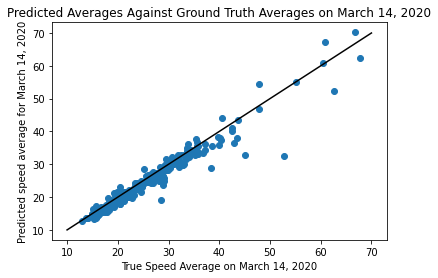

In [63]:
plt.title("Predicted Averages Against Ground Truth Averages on March 14, 2020")
predicted_y_post = reg.predict(time_series_x_pre_no_na)
plt.scatter(time_series_y_post_no_na, predicted_y_post)
plt.ylabel("Predicted speed average for March 14, 2020")
plt.xlabel("True Speed Average on March 14, 2020")
plt.plot([10, 70], [10,70], 'k', alpha = 0.99)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 4.b.ii. Report model performance temporally

1. **Make a line plot** showing performance of the original model throughout all of March 2020.
2. **Report the lowest point on the line plot**, reflecting the lowest model performance.
2. **Why is model performance the worst on the 17th?** Why does it begin to worsen on march 15th? And continue to worsen? Use what you know about covid measures on those dates. You may find this webpage useful: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/
3. **Is the dip in performance on the 9th foreshadowed** by any of our EDA?
4. **How does the model miraculously recover on its own?**
5. **Make a scatter plot**, plotting predicted averages against ground truth averages *for model predictions on March 17th*. Note the perfect model would line up all points along the line $y=x$. When compared against previous plots of this nature, this plot looks substantially worse, with points straying far from $y=x$.

**Note:** Answer questions 2-5 in the Markdown cell below. Q1 and Q6 are answered in the two code cells below.

<!--
BEGIN QUESTION
name: q4bii1
points: 3
manual: True
-->



_2. Reflecting the lowest model performance, the lowest point on the line plot is March 17th with an R^2 value of 0.7248438392437919 or (17, 0.7248438392437919)._

_3. The model performance is the worst on the 17th because San Francisco and the entire Bay Area moved into phase two of the covid restrictions and lockdowns on March 18th. So it is difficult to train on this data because the traffic was varying greatly as people in the Bay Area were either not leaving their homes for the impending lockdown or running frantically around to secure food or toilet paper or whatever the scared Bay Areians thought they needed. It begins to worsen on March 15th because on the 14th Marin also announces plans to advance to phase 2 on the 18th as well. So it continues to worsen up until the 17th as people prepare for lockdown._

_4. Yes the dip in performance on the 9th is foreshadowed due to the fact that we see a continually declining performance from March 6th to 8th or 9th. These couple days are also difficult to train on as the impending pandemic had really just become a reality for most and the traffic patterns were changing sporadically. So yes, the dip in performance on the 9th is foreshadowed by the days preceding it._

_5. The model does not 'miraculously' recover on its own but rather the data points become more consistent and there becomes room for greater training and test model accuracy. The data points become more consistent as the greater SF area acclimates to the lockdown, making traffic more predictable, and in turn allows our model to recover in performance._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate line plot.
<!--
BEGIN QUESTION
name: q4bii2
points: 1
manual: True
-->

Text(0, 0.5, 'R^2 coefficient that is trained on the previous 5 days')

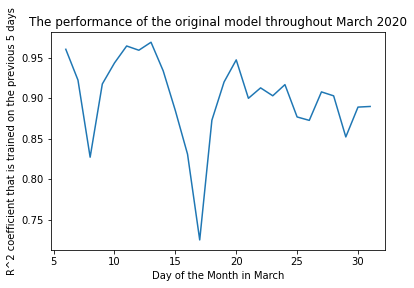

In [64]:
# r_day_data_points = []
r_day_data_points, index = np.zeros([26,2]), 0
start, end = 1, 5
for day in np.arange(6, 31+1):
    previous_5_days = time_series.loc[:, start: end].to_numpy()
    next_day = time_series.iloc[:, end].to_numpy()
    
    
    previous_5_days_no_na, next_day_no_na = remove_nans(previous_5_days, next_day)
    
    next_day_score = reg.score(previous_5_days_no_na, next_day_no_na)
    # r_day_data_points.append([next_day_score, day])
    r_day_data_points[index] = [next_day_score, day]
    start += 1
    end += 1
    index += 1
  
x, y = r_day_data_points.T

plt.title("The performance of the original model throughout March 2020")
plt.plot(y, x)
plt.xlabel("Day of the Month in March")
plt.ylabel("R^2 coefficient that is trained on the previous 5 days")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate a scatter plot.
<!--
BEGIN QUESTION
name: q4bii3
points: 1
manual: True
-->

Text(0, 0.5, 'Predicted Speed Averages on March 17th')

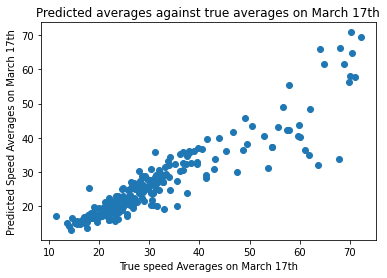

In [65]:
days_before_17th = time_series.loc[:, 12:16]
truth_17th = time_series.loc[:, 17].to_numpy()

days_before_17th_no_na, truth_17th_no_na = remove_nans(days_before_17th, truth_17th)
predicted_17th = reg.predict(days_before_17th_no_na)
plt.scatter(truth_17th_no_na, predicted_17th)
plt.title("Predicted averages against true averages on March 17th")
plt.xlabel("True speed Averages on March 17th")
plt.ylabel("Predicted Speed Averages on March 17th")

<!-- END QUESTION -->



## 4.c. "Fix" model on post-lockdown data

Per this survey https://pure.tue.nl/ws/files/3488790/740215.pdf, there are 4 categories of fixes for change points:
- Forgetting mechanisms
- Explicit change detection
- Ensemble techniques
- Context-aware approaches

In this part, we'll combine insights in model errors with previous EDA insights to produce a fix.

<!-- BEGIN QUESTION -->

### 4.c.i. Learn delta off of a moving bias

According to our previous work in EDA, the average speed shoots upwards sharply. As a result, our trick to learn delta the around the average and to naively assume that the average of day $t$ is the average for day $t+1$. We will do this in 4 steps:

1. **Create a dataset for your delta model**.
2. **Train your delta model** on pre-lockdown data.
3. **Evaluate your model on pre-lockdown data**, to ensure that the model has learned to a satisfactory degree, in the nominal case. Remember the naive model achieved 0.97 r^2 on pre-lockdown data.
4. **Evaluate your model on the 17th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score has improved by 10%+. Why is your delta model so effective for the 17th?
5. **Evaluate your model on the 14th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score is now complete garbage. Why is your delta so ineffective for the 14th?

**Hint**: As you build your datasets, always check to make sure you're using the right days! It's easy to have a one-off error that throws off your results.

Write your written questions in the next cell, then write the code in the following cells.

<!--
BEGIN QUESTION
name: q4ci1
points: 2
manual: True
-->

_4. Our delta model is so effective for the 17th because 'delta' is the difference between the actual sample value and a running average, which makes this 'relative' data easier to predict compared to 'absolute' data, which we were previously using. The R^2 values were consistently declining in the days leading up to the 17th, so these values lowered the running average and thus allowed our R^2 score to improve by 10% under the delta or 'relative' data model._

_5. Our delta model is so ineffective for the 14th because even though using a delta model makes 'relative' data easier to predcit compared to 'absolute' data, it does not always improve performance, unlike the improvement in performance for March 17th. Our R^2 score is now 'complete garbage' because we are using a relative data model, comparing the our data to the running average, and the following days are increasing in performance. So as traffic in SF becomes increasingly more volatile starting on March 14th, the running average is high which creates a larger gap between the sample value and running average, lowering our performance (one could say 'complete garbage' levels of low)._


<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4ci2
points: 1
-->

In [66]:
time_series_delta = time_series_pre.subtract(speeds_daily).dropna(axis = 1, how = "all") # subtract daily average from pre-lockdown 'time series' dataframe `time_series_pre`
time_series_delta

day,1,2,3,4,5,6,7,8,9,10,11,12,13
MOVEMENT_ID,,,,,,,,,,,,,
9,-7.436210,-7.929735,-7.957726,-7.706332,-7.673488,-8.288859,-7.342673,-7.838718,-8.163539,-7.950124,-9.037052,-8.687048,-9.364599
20,-6.215082,-6.863900,-6.363125,-6.511982,-6.693731,-6.873540,-5.762984,-5.960594,-6.830754,-7.366163,-8.139844,-8.795882,-8.883074
21,-8.491956,-9.147858,-8.044932,-7.879632,-7.907553,-8.464493,-8.893040,-9.407162,-7.392644,-7.811186,-8.986853,-8.505135,-8.143181
44,1.446417,1.167730,0.901289,0.342397,-0.110985,0.981564,0.024509,1.604391,0.492527,0.078211,0.979607,1.910786,-0.144157
78,-7.458664,-5.569360,-5.787301,-5.813345,-6.320619,-6.303126,-7.548693,-4.765377,-6.755502,-6.530367,-7.003837,-6.987069,-7.112274
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,-3.385687,-4.313850,0.621691,NaN,-3.970859,NaN,NaN,-0.971484,NaN
2694,-5.823366,-5.598968,-5.295639,-5.485229,-5.482634,-5.448377,-5.423980,-5.992169,-5.698587,-5.662927,-5.885166,-6.070161,-5.761289
2695,-3.527067,-2.096006,-1.977287,-1.785869,0.371917,-2.850371,-3.627592,-4.578175,-2.511783,-2.260573,1.093583,-2.863087,-2.977301


In [67]:
grader.check("q4ci2")

q4ci2 results: All test cases passed!

In [68]:
X_delta_train, y_delta_train, X_delta_val, y_delta_val = time_series_to_dataset(time_series_delta, 5, 2)
reg_delta = LinearRegression().fit(X_delta_train, y_delta_train)
res_4ci3 = reg_delta.score(X_delta_val, y_delta_val) # learning delta as easy as learning original dataset!
res_4ci3

0.9645254590172871

In [69]:
grader.check("q4ci3")

q4ci3 results: All test cases passed!

In [70]:
delta_days_before_17th = time_series.subtract(speeds_daily).dropna(axis = 1, how = "all").loc[:, 12:16].to_numpy()
truth_17th_minus_speeds_daily = truth_17th - speeds_daily[17]
removed_na = remove_nans(delta_days_before_17th, truth_17th_minus_speeds_daily)
res_4ci4 = reg_delta.score(removed_na[0], removed_na[1])
res_4ci4

0.8346539614612526

In [71]:
grader.check("q4ci4")

q4ci4 results:
    q4ci4 - 1 result:
        Trying:
            np.isclose(res_4ci4, 0.8616633417528182, rtol=1e-4, atol=1e-4)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ci4 0
        Failed example:
            np.isclose(res_4ci4, 0.8616633417528182, rtol=1e-4, atol=1e-4)
        Expected:
            True
        Got:
            False

In [72]:
res_4ci5 = ...

In [73]:
grader.check("q4ci5")

q4ci5 results:
    q4ci5 - 1 result:
        Trying:
            np.isclose(res_4ci5, 0.11611253470677951, rtol=1e-4, atol=1e-4)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ci5 0
        Failed example:
            np.isclose(res_4ci5, 0.11611253470677951, rtol=1e-4, atol=1e-4)
        Exception raised:
            Traceback (most recent call last):
              File "/opt/conda/lib/python3.9/doctest.py", line 1336, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q4ci5 0[0]>", line 1, in <module>
                np.isclose(res_4ci5, 0.11611253470677951, rtol=1e-4, atol=1e-4)
              File "<__array_function__ internals>", line 5, in isclose
              File "/opt/conda/lib/python3.9/site-packages/numpy/core/numeric.py", line 2355, in isclose
                xfin = isfinite(x)
            TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

### 4.c.ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?

Had we ignored the problem, would we have been okay? The temporal plot above showing performance over time suggests a partial recovery. **Evaluate the original, naive model on all post-lockdown data** to see. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4cii
points: 1
-->

In [74]:
time_series_post = time_series.loc[:, 14:]

X_train_post, y_train_post, X_val_post, y_val_post = time_series_to_dataset(time_series_post, 5, 0)
score_og_post = reg.score(X_train_post, y_train_post)
score_og_post

0.9014738674628208

In [75]:
grader.check("q4cii")

q4cii results: All test cases passed!

### 4.c.iii. Naively retrain model with post-lockdown data

Can we use the same tactics--that we used to train the original model on pre-lockdown data--to train on the post-lockdown data? **Retrain a linear model and evaluate on post-lockdown data only**. You should construct a new dataset using `time_series_to_dataset` using only time series from March 14 to March 31. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4ciii
points: 1
-->

In [76]:
naive_X_train_post, naive_y_train_post, naive_X_val_post, naive_y_val_post = time_series_to_dataset(time_series_post, 5, 2)

naive_Model = LinearRegression().fit(naive_X_train_post, naive_y_train_post)
score_post = naive_Model.score(naive_X_val_post, naive_y_val_post)
score_post

0.8993687576351703

In [77]:
grader.check("q4ciii")

q4ciii results: All test cases passed!

### 4.c.iv. What if you just ignore the change point?

Turns out, this is no good. Even acknowledging the change point and training *either* before *or* after is better. Being ignorant and training on *both* is the worst option, producing a lower r^2.

<!--
BEGIN QUESTION
name: q4civ
points: 1
-->

In [78]:
no_X_train_post, no_y_train_post, no_X_val_post, no_y_val_post = time_series_to_dataset(time_series, 5, 5)
no_change_model = LinearRegression().fit(no_X_train_post, no_y_train_post)
res_4civ = no_change_model.score(no_X_val_post, no_y_val_post)
# res_4civ
time_series

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
MOVEMENT_ID,,,,,,,,,,,,,,,,,,,,,
9,16.196918,14.395121,13.868696,14.225414,14.312199,13.811991,15.508637,16.210738,14.845320,14.711534,...,15.880078,17.019573,15.527393,15.925605,15.959744,17.317841,17.845053,17.839214,15.743376,15.797248
20,17.418045,15.460956,15.463297,15.419764,15.291956,15.227310,17.088325,18.088862,16.178105,15.295494,...,18.843376,17.029943,16.286795,17.007889,15.205696,17.461643,16.997424,19.024721,14.134949,17.287814
21,15.141171,13.176998,13.781490,14.052113,14.078134,13.636357,13.958269,14.642295,15.616215,14.850471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,25.079544,23.492586,22.727711,22.274143,21.874703,23.082414,22.875819,25.653848,23.501387,22.739869,...,24.381933,25.350188,31.126033,NaN,22.518500,27.697570,26.899667,19.777429,24.385409,24.683422
78,16.174464,16.755496,16.039120,16.118401,15.665069,15.797723,15.302616,19.284080,16.253357,16.131290,...,NaN,NaN,15.690000,NaN,NaN,16.849000,NaN,NaN,16.493000,16.767400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,18.600000,17.787000,23.473000,NaN,19.038000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2694,17.809761,16.725889,16.530783,16.446517,16.503053,16.652473,17.427329,18.057287,17.310272,16.998730,...,23.886576,23.410192,23.302396,23.031966,23.107702,23.581885,24.382866,23.278001,23.426889,24.056357
2695,20.106061,20.228850,19.849135,20.145877,22.357605,19.250479,19.223717,19.471282,20.497077,20.401085,...,29.218800,NaN,NaN,NaN,23.396500,NaN,19.708000,26.461900,NaN,19.959500


In [79]:
grader.check("q4civ")

q4civ results: All test cases passed!

# Step 5 - Open-Ended Modeling: Predicting travel time post-lockdown

*This* is the real deal and ultimately what Uber cares about. Traffic speeds is a proxy task, but the bottom line and moneymaking machine relies on this travel time estimation. Focus on designing experiments instead of focusing on experimental, quantitative results. Your experiments are successful if they inform a decision, even despite a lower-performing model.

## Question 5a

Train a baseline model of your choice using any supervised learning approach we have studied; you are not limited to a linear model.


**Example**

Given the data for this question, you could build a model to predict travel time from Cheesecake Factory to UC Berkeley.

In [80]:
bart = pd.read_csv(r'data/date-hour-soo-dest-2021.csv')
bart.columns = ["date", "hour", "start", "end", "count"]
WOAK_start = bart[bart["start"] == "DBRK"]
berkeley_SF = WOAK_start[WOAK_start["end"] == "CIVC"] # starts on WOAK and ends on POWL
berkeley_SF

,date,hour,start,end,count
1303,2021-01-01,10,DBRK,CIVC,2
1842,2021-01-01,11,DBRK,CIVC,1
2408,2021-01-01,12,DBRK,CIVC,1
2982,2021-01-01,13,DBRK,CIVC,2
3580,2021-01-01,14,DBRK,CIVC,1
...,...,...,...,...,...
6015369,2021-12-02,19,DBRK,CIVC,6
6016563,2021-12-02,20,DBRK,CIVC,6
6017519,2021-12-02,21,DBRK,CIVC,7
6018359,2021-12-02,22,DBRK,CIVC,3


In [81]:
copy = berkeley_SF.copy()
copy['date'] = pd.to_datetime(copy['date'])
copy["Day_of_Week"] = copy["date"].dt.day_name()
Berkeley_SF = copy
Berkeley_SF

,date,hour,start,end,count,Day_of_Week
1303,2021-01-01,10,DBRK,CIVC,2,Friday
1842,2021-01-01,11,DBRK,CIVC,1,Friday
2408,2021-01-01,12,DBRK,CIVC,1,Friday
2982,2021-01-01,13,DBRK,CIVC,2,Friday
3580,2021-01-01,14,DBRK,CIVC,1,Friday
...,...,...,...,...,...,...
6015369,2021-12-02,19,DBRK,CIVC,6,Thursday
6016563,2021-12-02,20,DBRK,CIVC,6,Thursday
6017519,2021-12-02,21,DBRK,CIVC,7,Thursday
6018359,2021-12-02,22,DBRK,CIVC,3,Thursday


Text(0, 0.5, 'Average Number of Bart Riders')

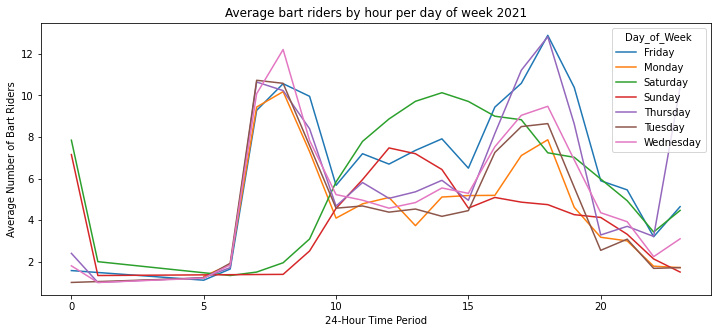

In [82]:
# Average Number of Bart Riders
import seaborn as sns
plt.figure(figsize = (12, 5))
count_hours = pd.DataFrame(Berkeley_SF.groupby(["Day_of_Week", "hour"]).agg("mean"))

sns.lineplot(x = "hour", y = "count", data = count_hours, hue = "Day_of_Week")
plt.title("Average bart riders by hour per day of week 2021")
plt.xlabel("24-Hour Time Period")
plt.ylabel("Average Number of Bart Riders")

Text(0, 0.5, 'Average Number of Bart Riders')

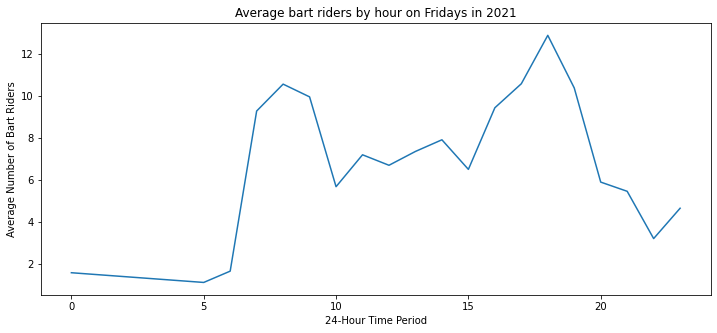

In [83]:
# filtered to Friday only
Friday = Berkeley_SF[Berkeley_SF["Day_of_Week"] == "Friday"]
plt.figure(figsize = (12, 5))
Friday_count_hours = pd.DataFrame(Friday.groupby(["Day_of_Week", "hour"]).agg("mean"))

sns.lineplot(x = "hour", y = "count", data = Friday_count_hours)
plt.title("Average bart riders by hour on Fridays in 2021")
plt.xlabel("24-Hour Time Period")
plt.ylabel("Average Number of Bart Riders")

Text(0, 0.5, 'Average Number of Bart Riders')

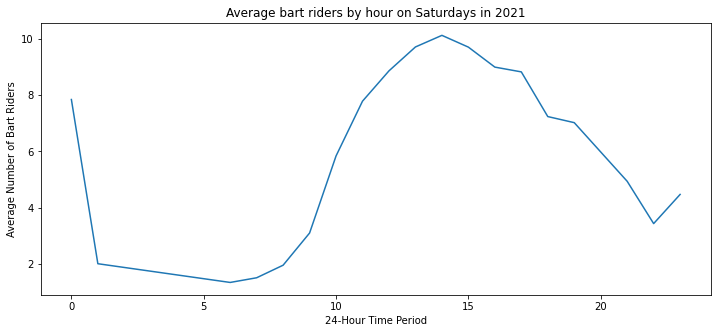

In [84]:
# filtered to Saturdays only
Saturday = Berkeley_SF[Berkeley_SF["Day_of_Week"] == "Saturday"]
plt.figure(figsize = (12, 5))
Saturday_count_hours = pd.DataFrame(Saturday.groupby(["Day_of_Week", "hour"]).agg("mean"))

sns.lineplot(x = "hour", y = "count", data = Saturday_count_hours)
plt.title("Average bart riders by hour on Saturdays in 2021")
plt.xlabel("24-Hour Time Period")
plt.ylabel("Average Number of Bart Riders")

Text(0, 0.5, 'Average Number of Bart Riders')

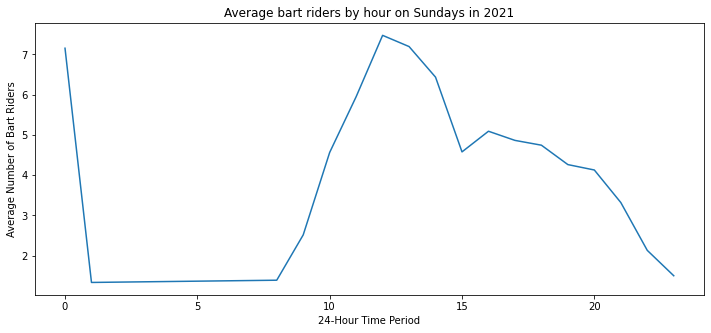

In [85]:
# filtered to Sundays only
Sunday = Berkeley_SF[Berkeley_SF["Day_of_Week"] == "Sunday"]
plt.figure(figsize = (12, 5))
Sunday_count_hours = pd.DataFrame(Sunday.groupby(["Day_of_Week", "hour"]).agg("mean"))

sns.lineplot(x = "hour", y = "count", data = Sunday_count_hours)
plt.title("Average bart riders by hour on Sundays in 2021")
plt.xlabel("24-Hour Time Period")
plt.ylabel("Average Number of Bart Riders")

Text(0, 0.5, 'Average Number of Bart Riders')

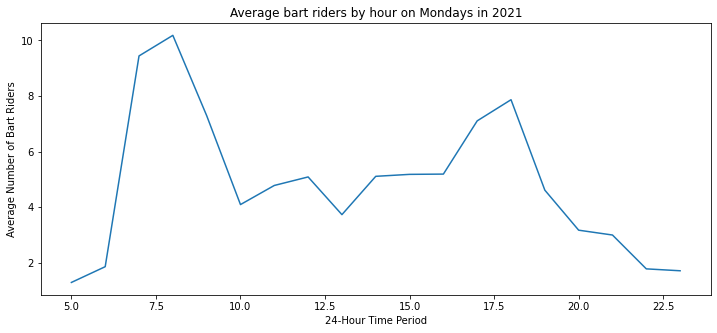

In [86]:
# filtered to Mondays only
Monday = Berkeley_SF[Berkeley_SF["Day_of_Week"] == "Monday"]
plt.figure(figsize = (12, 5))
Monday_count_hours = pd.DataFrame(Monday.groupby(["Day_of_Week", "hour"]).agg("mean"))
sns.lineplot(x = "hour", y = "count", data = Monday_count_hours)
plt.title("Average bart riders by hour on Mondays in 2021")
plt.xlabel("24-Hour Time Period")
plt.ylabel("Average Number of Bart Riders")

Text(0, 0.5, 'Average Number of Bart Riders')

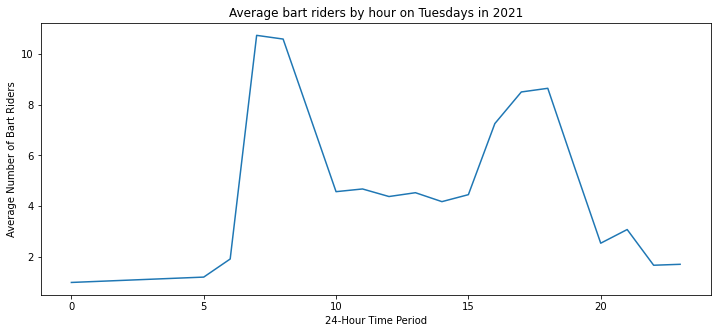

In [87]:
# filtered to Tuesdays only
Tuesday = Berkeley_SF[Berkeley_SF["Day_of_Week"] == "Tuesday"]
plt.figure(figsize = (12, 5))
Tuesday_count_hours = pd.DataFrame(Tuesday.groupby(["Day_of_Week", "hour"]).agg("mean"))
sns.lineplot(x = "hour", y = "count", data = Tuesday_count_hours)
plt.title("Average bart riders by hour on Tuesdays in 2021")
plt.xlabel("24-Hour Time Period")
plt.ylabel("Average Number of Bart Riders")

Text(0, 0.5, 'Average Number of Bart Riders')

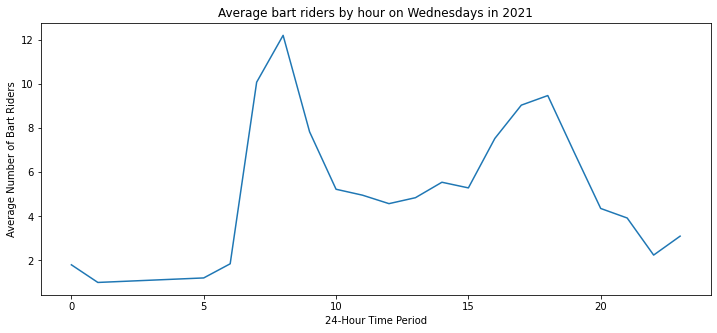

In [88]:
# filtered to Wednesdays only
Wednesday = Berkeley_SF[Berkeley_SF["Day_of_Week"] == "Wednesday"]
plt.figure(figsize = (12, 5))
Wednesday_count_hours = pd.DataFrame(Wednesday.groupby(["Day_of_Week", "hour"]).agg("mean"))

sns.lineplot(x = "hour", y = "count", data = Wednesday_count_hours)
plt.title("Average bart riders by hour on Wednesdays in 2021")
plt.xlabel("24-Hour Time Period")
plt.ylabel("Average Number of Bart Riders")

Text(0, 0.5, 'Average Number of Bart Riders')

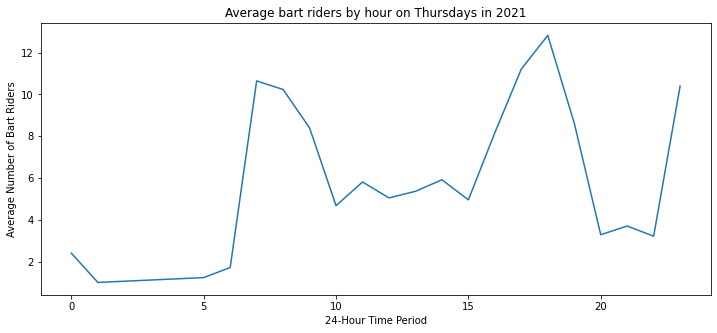

In [89]:
# filtered to Thursdays only
Thursday = Berkeley_SF[Berkeley_SF["Day_of_Week"] == "Thursday"]
plt.figure(figsize = (12, 5))
Thursday_count_hours = pd.DataFrame(Thursday.groupby(["Day_of_Week", "hour"]).agg("mean"))

sns.lineplot(x = "hour", y = "count", data = Thursday_count_hours)
plt.title("Average bart riders by hour on Thursdays in 2021")
plt.xlabel("24-Hour Time Period")
plt.ylabel("Average Number of Bart Riders")

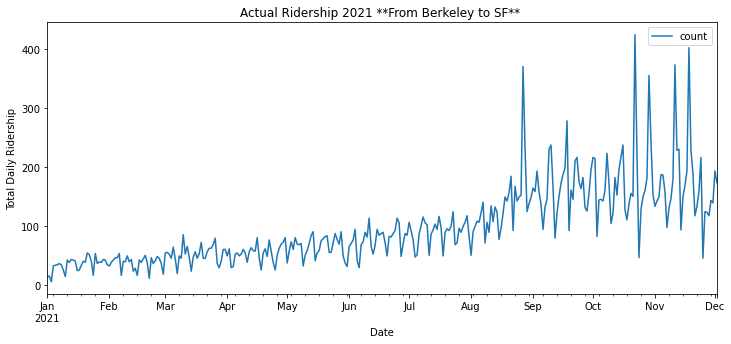

In [90]:
total_riders_by_date = pd.DataFrame(Berkeley_SF.groupby("date").agg(sum)).drop(labels = "hour", axis = 1)
total_riders_by_date
total_riders_by_date.plot(figsize=(12,5))
plt.title("Actual Ridership 2021 **From Berkeley to SF** ")
plt.ylabel("Total Daily Ridership")
plt.xlabel("Date")
plt.legend()

In [91]:
import datetime

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

In [92]:
forecast = 30
total_riders_by_date['Prediction'] = total_riders_by_date[['count']].shift(-forecast)

X = np.array(total_riders_by_date.drop(['Prediction'], 1))
X = preprocessing.scale(X)

X_forecast = X[-forecast:]
X = X[:-forecast]

y = np.array(total_riders_by_date['Prediction'])
y = y[:-forecast]
# total_riders_by_date.tail(32)

/tmp/ipykernel_134/3840443654.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = np.array(total_riders_by_date.drop(['Prediction'], 1))


In [93]:
# now everything is shifted back 30 days, as if November to December has not happened yet
# total_riders_by_date.plot()
new_df = total_riders_by_date.loc[:, ["Prediction"]]

In [94]:
#created test and trained data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#fit the model
clf = LinearRegression()
clf.fit(X_train, y_train)

#check accuracy
confidence = clf.score(X_test, y_test)

#predict values
forecast_predicted = clf.predict(X_forecast)

print(confidence)

0.31777979072977514


In [95]:
forecast_predicted

actual_count_last30_days = total_riders_by_date.iloc[306:, 0].to_numpy()
actual_count_last30_days - forecast_predicted
# total_riders_by_date

array([  8.52087212,  23.14805534,  22.76312947,  11.98520499,
       -11.49527333,   1.20728051,   7.3660945 ,  19.68372247,
        94.74426794,  38.93001618,  39.69986793, -13.03497683,
         8.52087212,  15.83446373,  25.45761059, 105.90711829,
        38.93001618,  23.91790709,  -3.79675585,   2.36205814,
        11.98520499,  34.31090569, -31.51141879,  -1.10227473,
        -1.48720061,  -3.79675585,   6.21131688,   4.67161338,
        25.45761059,  17.7590931 ])

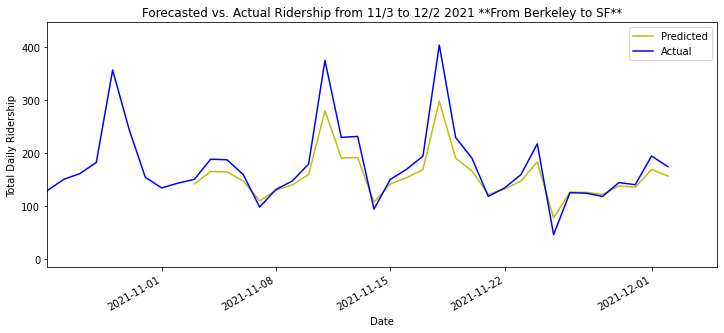

In [96]:
#plot prediction
dates = pd.date_range(start = "2021-11-03", end="2021-12-02")
plt.plot(dates,forecast_predicted, color = 'y', label = "Predicted")
total_riders_by_date['count'].plot(color='b', figsize = (12,5), label ="Actual")

# take a closer look from October 25st to December 2nd
plt.xlim(xmin=datetime.date(2021,10,25), xmax=datetime.date(2021,12,5))
plt.title("Forecasted vs. Actual Ridership from 11/3 to 12/2 2021 **From Berkeley to SF**")
plt.ylabel("Total Daily Ridership")
plt.xlabel("Date")
plt.legend()

## Question 5b

Improve on your baseline model. Specify the model you designed and its input features. Justify why you chose these features and their relevance to your model's predictions.

**Example**

Here are potential questions to consider for this part: How does the other variant of your travel times dataset, aggregated across time but reported for all routes, useful?  What additional data from the Uber Movement website can you export to better your model?

In [97]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
bart2 = pd.read_csv(r'data/date-hour-soo-dest-2021.csv')
bart2.columns = ["date", "hour", "start", "end", "count"]

In [98]:
bart2

,date,hour,start,end,count
0,2021-01-01,6,EMBR,EMBR,2
1,2021-01-01,6,LAKE,POWL,1
2,2021-01-01,7,12TH,DBRK,1
3,2021-01-01,7,12TH,POWL,1
4,2021-01-01,7,16TH,POWL,1
...,...,...,...,...,...
6019498,2021-12-02,23,WOAK,DALY,1
6019499,2021-12-02,23,WOAK,MONT,2
6019500,2021-12-02,23,WOAK,PCTR,2
6019501,2021-12-02,23,WOAK,PITT,1


(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 [Text(-50.0, 0, '2021-10-14'),
  Text(0.0, 0, '2021-01-01'),
  Text(50.0, 0, '2021-02-20'),
  Text(100.0, 0, '2021-04-11'),
  Text(150.0, 0, '2021-05-31'),
  Text(200.0, 0, '2021-07-20'),
  Text(250.0, 0, '2021-09-08'),
  Text(300.0, 0, '2021-10-28'),
  Text(350.0, 0, ''),
  Text(400.0, 0, '')])

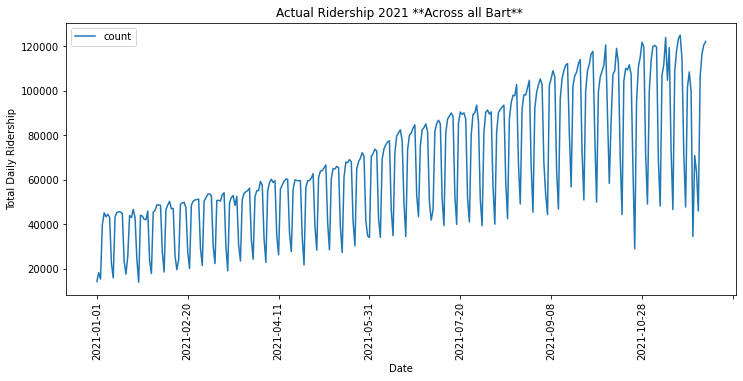

In [99]:
total_riders_by_date2 = pd.DataFrame(bart2.groupby("date").agg(sum)).drop(labels = "hour", axis = 1)
total_riders_by_date2
total_riders_by_date2.plot(figsize = (12, 5))

plt.title("Actual Ridership 2021 **Across all Bart** ")
plt.ylabel("Total Daily Ridership")
plt.xlabel("Date")
plt.legend()
plt.xticks(rotation = "vertical")

In [100]:
forecast = 30
total_riders_by_date2['Prediction'] = total_riders_by_date2[['count']].shift(-forecast)

X = np.array(total_riders_by_date2.drop(['Prediction'], 1))
X = preprocessing.scale(X)

X_forecast = X[-forecast:]
X = X[:-forecast]

y = np.array(total_riders_by_date2['Prediction'])
y = y[:-forecast]

/tmp/ipykernel_134/3580822687.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = np.array(total_riders_by_date2.drop(['Prediction'], 1))


In [101]:
# now everything is shifted back 30 days, as if November to December has not happened yet
# total_riders_by_date.plot()
new_df = total_riders_by_date2.loc[:, ["Prediction"]]
new_df.tail(32)

,Prediction
date,
2021-11-01,120529.0
2021-11-02,122133.0
2021-11-03,NaN
2021-11-04,NaN
2021-11-05,NaN
2021-11-06,NaN
2021-11-07,NaN
2021-11-08,NaN
2021-11-09,NaN


In [102]:
#created test and trained data set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#fit the model
clf = LinearRegression()
clf.fit(X_train, y_train)

#check accuracy
confidence = clf.score(X_test, y_test)
#predict values
forecast_predicted = clf.predict(X_forecast)

print(confidence)

0.2060369621975302


In [103]:
forecast_predicted

actual_count_last30_days = total_riders_by_date2.iloc[306:, 0].to_numpy()
actual_count_last30_days - forecast_predicted

array([ 28805.01884139,  29087.93367202,  28642.09021125,  -3375.91163656,
       -16473.98418592,  20665.53390389,  23662.66289088,  31349.98930443,
        19211.17485268,  28450.74379679,   -594.75781044, -17453.45048572,
        21650.68376055,  27503.48431923,  30972.34852605,  32013.07093873,
        25261.00538269,  -1875.4526241 , -16739.21683964,  17206.14229184,
        21571.11396443,  16061.85284295, -25101.62350753,  -2138.15925255,
        -6959.078487  , -17884.13779485,  20244.95069585,  26752.62330668,
        29197.81577142,  30210.75190609])

(array([18936., 18940., 18944., 18948., 18952., 18956., 18960., 18962.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

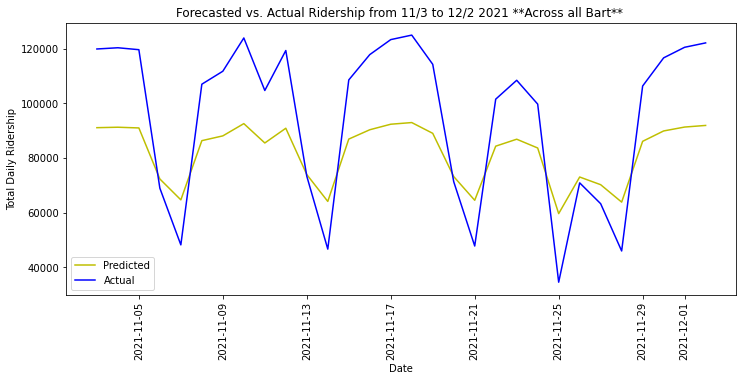

In [104]:
#plot prediction
dates = pd.date_range(start = "2021-11-03", end="2021-12-02")
plt.figure(figsize = (12, 5))
plt.plot(dates,forecast_predicted, color = 'y', label = "Predicted")
plt.plot(dates, actual_count_last30_days, color='b', label = "Actual")

# take a closer look from November 3rd to December 2nd
plt.title("Forecasted vs. Actual Ridership from 11/3 to 12/2 2021 **Across all Bart** ")
plt.ylabel("Total Daily Ridership")
plt.xlabel("Date")
plt.legend()
plt.xticks(rotation = "vertical")

## Question 5c

Explore other modeling aspects and/or temporal information. You are free to relate this to your hypothesis or not. Please expand into multiple parts that logically separate and break down your modeling work!

**Example**

For example, explore change across time, before and after the lockdown: (a) train and evaluate on *pre*-lockdown traffic travel times for that route; and (b) evaluate your model on *post*-lockdown traffic patterns.
How would you correct your model for a more accurate post-lockdown traffic predictor? *The above is just a suggestion. You may pick any topic you find interesting.*

In [105]:
# loading dataset (Bart transportation in the Bay)
bart_2020 = pd.read_csv(r'data/date-hour-soo-dest-2020.csv')
bart_2020.columns = ["date", "hour", "start", "end", "count"]

In [106]:
bart_pre = bart_2020[bart_2020["date"] < "2020-03-20"]
bart_pre = pd.DataFrame(bart_pre.groupby("date").agg("sum").drop("hour", axis =1))

In [107]:
forecast = 30
bart_pre['Prediction'] = bart_pre[['count']].shift(-forecast)

X = np.array(bart_pre.drop(['Prediction'], 1))
X = preprocessing.scale(X)

X_forecast = X[-forecast:]
X = X[:-forecast]

y = np.array(bart_pre['Prediction'])
y = y[:-forecast]
bart_pre.tail(30)

/tmp/ipykernel_134/707102486.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = np.array(bart_pre.drop(['Prediction'], 1))


,count,Prediction
date,,
2020-02-17,157451,NaN
2020-02-18,413595,NaN
2020-02-20,417083,NaN
2020-02-21,382034,NaN
2020-02-22,151264,NaN
2020-02-23,101711,NaN
2020-02-25,426135,NaN
2020-02-26,420537,NaN
2020-02-27,423117,NaN


In [108]:
#created test and trained data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#fit the model
model = LinearRegression()
model.fit(X_train, y_train)

#check accuracy
confidence = model.score(X_test, y_test)
#predict values
forecast_predicted = model.predict(X_forecast)

print(confidence)

forecast_predicted

actual_count_last30_days = bart_pre.iloc[46:76, :]

0.17440158573514253


DatetimeIndex(['2021-11-03', '2021-11-04', '2021-11-05', '2021-11-06',
               '2021-11-07', '2021-11-08', '2021-11-09', '2021-11-10',
               '2021-11-11', '2021-11-12', '2021-11-13', '2021-11-14',
               '2021-11-15', '2021-11-16', '2021-11-17', '2021-11-18',
               '2021-11-19', '2021-11-20', '2021-11-21', '2021-11-22',
               '2021-11-23', '2021-11-24', '2021-11-25', '2021-11-26',
               '2021-11-27', '2021-11-28', '2021-11-29', '2021-11-30',
               '2021-12-01', '2021-12-02'],
              dtype='datetime64[ns]', freq='D')

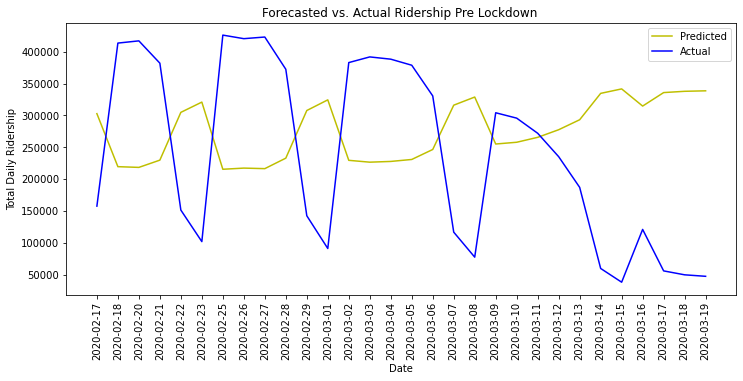

In [109]:
#plot prediction
plt.figure(figsize = (12, 5))
plt.plot(forecast_predicted, color = 'y', label = "Predicted")
plt.plot(actual_count_last30_days['count'], 'b', label = "Actual")
plt.title("Forecasted vs. Actual Ridership Pre Lockdown ")
plt.ylabel("Total Daily Ridership")
plt.xlabel("Date")
plt.legend()
plt.xticks(rotation = "vertical")
dates

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [110]:
grader.check_all()

q1a results: All test cases passed!

q1bi results: All test cases passed!

q1bii results: All test cases passed!

q1biii results: All test cases passed!

q1biv results: All test cases passed!

q1bv3 results: All test cases passed!

q1ci results: All test cases passed!

q1cii results: All test cases passed!

q1ciii results: All test cases passed!

q1civ3 results: All test cases passed!

q2ai2 results:
    q2ai2 - 1 result:
        Trying:
            len(averages_pre) == 295
        Expecting:
            True
        **********************************************************************
        Line 1, in q2ai2 0
        Failed example:
            len(averages_pre) == 295
        Expected:
            True
        Got:
            False

    q2ai2 - 2 result:
        Trying:
            np.isclose(averages_pre.sum(), 6768.609943648161)
        Expecting:
            True
        **********************************************************************
        Line 1, in q2ai2 1
        F

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [111]:
# Save your notebook first, then run this cell to export your submission.
grader.export()